# La Mobilière Insurance Data - Analysis
Last modified by AB on the 12/06/2021

This notebooks performs the data validation and description presented in the paper. 
Pre-processed figures are saved in an ad-hoc folder, ready for processing.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline

import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches
import os
import glob
import palettable as pltt
from scipy.stats import pearsonr as pearcorr
pd.set_option('display.max_columns', None) 


plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

Populating the interactive namespace from numpy and matplotlib


## Geographic Information



In [2]:
colors = pltt.wesanderson.Darjeeling3_5.hex_colors

In [3]:
## Zip codes - commune codes
## Population
# 90 variables + BFS Code that identifies the municipalities
swissData = pd.read_csv('../Data/populationData.csv',encoding='iso-8859-1') 

In [4]:
zipShape = gpd.read_file("../Data/shapeFiles/zips.shp")
zipBFS_2019 = pd.read_csv("../Data/ZIP_BFS_Historical_Mapping/20191201/PLZO_CSV_WGS84.csv",encoding='iso-8859-1', sep=';')
#Merge in BFS
zipShape = zipShape.merge(zipBFS_2019, on='PLZ', how='inner' )
zipShape.rename(columns={'BFS-Nr':'BFS', 'PLZ':'ZIP'}, inplace=True)
munShape_2019 = zipShape.dissolve(by='BFS').reset_index()
zurich = munShape_2019[munShape_2019['BFS']==261]
zipZ = zipShape[zipShape['BFS']==261]
pZip = zipZ.geometry.unary_union
gdf2 = gpd.GeoDataFrame(geometry=[pZip], crs=zipZ.crs)

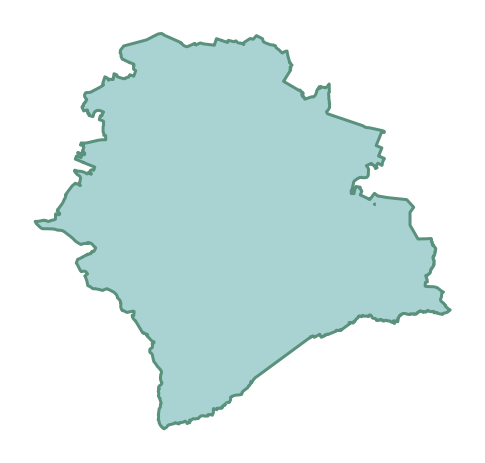

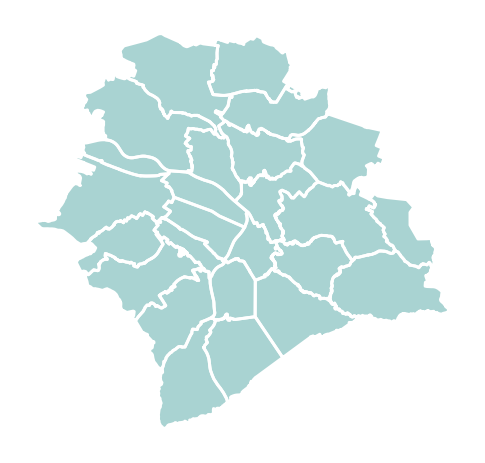

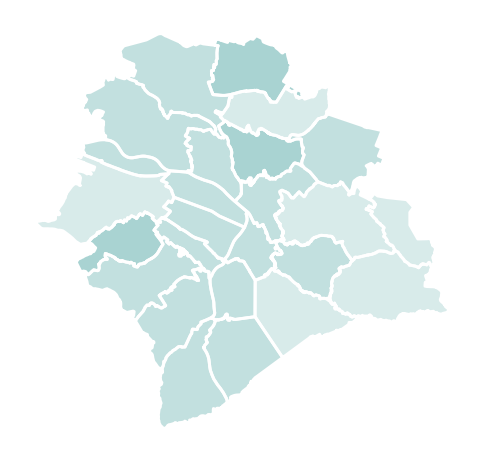

In [5]:
f,ax = plt.subplots()
gdf2.plot(ax=ax, color=colors[2])
gdf2.boundary.plot(ax=ax, color=colors[4], rasterized=True)
ax.axis('off')
f.savefig('../Figures/Pre-processing/Zurich_mun_full.png',dpi=300,bbox_inches='tight')

f,ax = plt.subplots()
zipZ.boundary.plot(ax=ax, color='white', rasterized=True)
zipZ.plot(ax=ax, color=colors[2])
ax.axis('off')
f.savefig('../Figures/Pre-processing/Zurich_zip_full.png',dpi=300,bbox_inches='tight')

dic={8048:0, 8053:0, 8044:0, 8008:0, 8047:2, 8052:2,  8050:0, 8057:2}
zipZ['for_ex']=1
zipZ['for_ex']=zipZ.apply(lambda x: dic[x['ZIP']] if str(x['ZIP']) in ['8057', '8048', '8053', '8044', '8008', '8047', '8052', '8050'] else x['for_ex'] , axis=1)
f,ax = plt.subplots()
zipZ.boundary.plot(ax=ax, color='white', rasterized=True)
zipZ[zipZ['for_ex']==0].plot(ax=ax, color=colors[2], alpha=0.45)
zipZ[zipZ['for_ex']==1].plot(ax=ax, color=colors[2], alpha=0.7)
zipZ[zipZ['for_ex']==2].plot(ax=ax, color=colors[2])
ax.axis('off')
f.savefig('../Figures/Pre-processing/Zurich_empty.png',dpi=300,bbox_inches='tight')

In [6]:
# Overall stats on municipalities
df = pd.read_excel('../Data/publicData/original/2020.xlsx',index_col=None, header=None, engine='openpyxl')
df = df[ (df.index>8)]
df = df.dropna()
df.rename(columns = {0:'BFS', 1:'Municipality', 2:'Residents'}, inplace = True)      
df = df[['BFS', 'Municipality', 'Residents']].reset_index(drop=True)


df_bfs_2018 = pd.read_csv('../Data/combinedData/municipality_combinedData_2018.csv')
tmp = pd.merge(df_bfs_2018[['BFS', 'custom']], df[['BFS', 'Residents']], on = 'BFS', how='right')
pop=tmp[tmp.custom.isnull()==False].Residents.sum()/tmp.Residents.sum()
print(tmp[tmp.custom.isnull()==False].Residents.sum())
print(tmp.Residents.sum())
print(pop)

8115301
8544527
0.9497659730023674


## Data overview

In [7]:
years = np.arange(2008, 2020, 1)
features=['custom', 'age_mean', 'frac_own', 'frac_foreign', 'child_mean', 'frac_women', 
         'car1_custom_frac','car1_pr_mean', 'car1_y_pct50', 'car1_ccm_mean', 'car1_claim_mean', 'car1_sumcl_mean', 'car1_prem_mean',
         'build_custom_frac','cl_furn_pct50', 'rooms_mean', 'build_ins_mean', 'build_y_pct50', 'build_claim_mean', 'build_sumcl_mean', 'build_prem_mean', ]


for year in  np.arange(2008, 2019, 1):
    data = pd.read_csv('../Data/aggregatedData/ZIP_%d.csv'%year)
    data[features].describe().transpose().to_csv('../Tables/Data_overview_%d.csv'%year,  float_format='%.2f')
    

for i,year in  enumerate(years):
    data = pd.read_csv('../Data/aggregatedData/ZIP_%d.csv'%year)
    data['year']=year
    if i==0:
        combined=data.copy()
    else:
        combined=combined.append(data, ignore_index=True)    

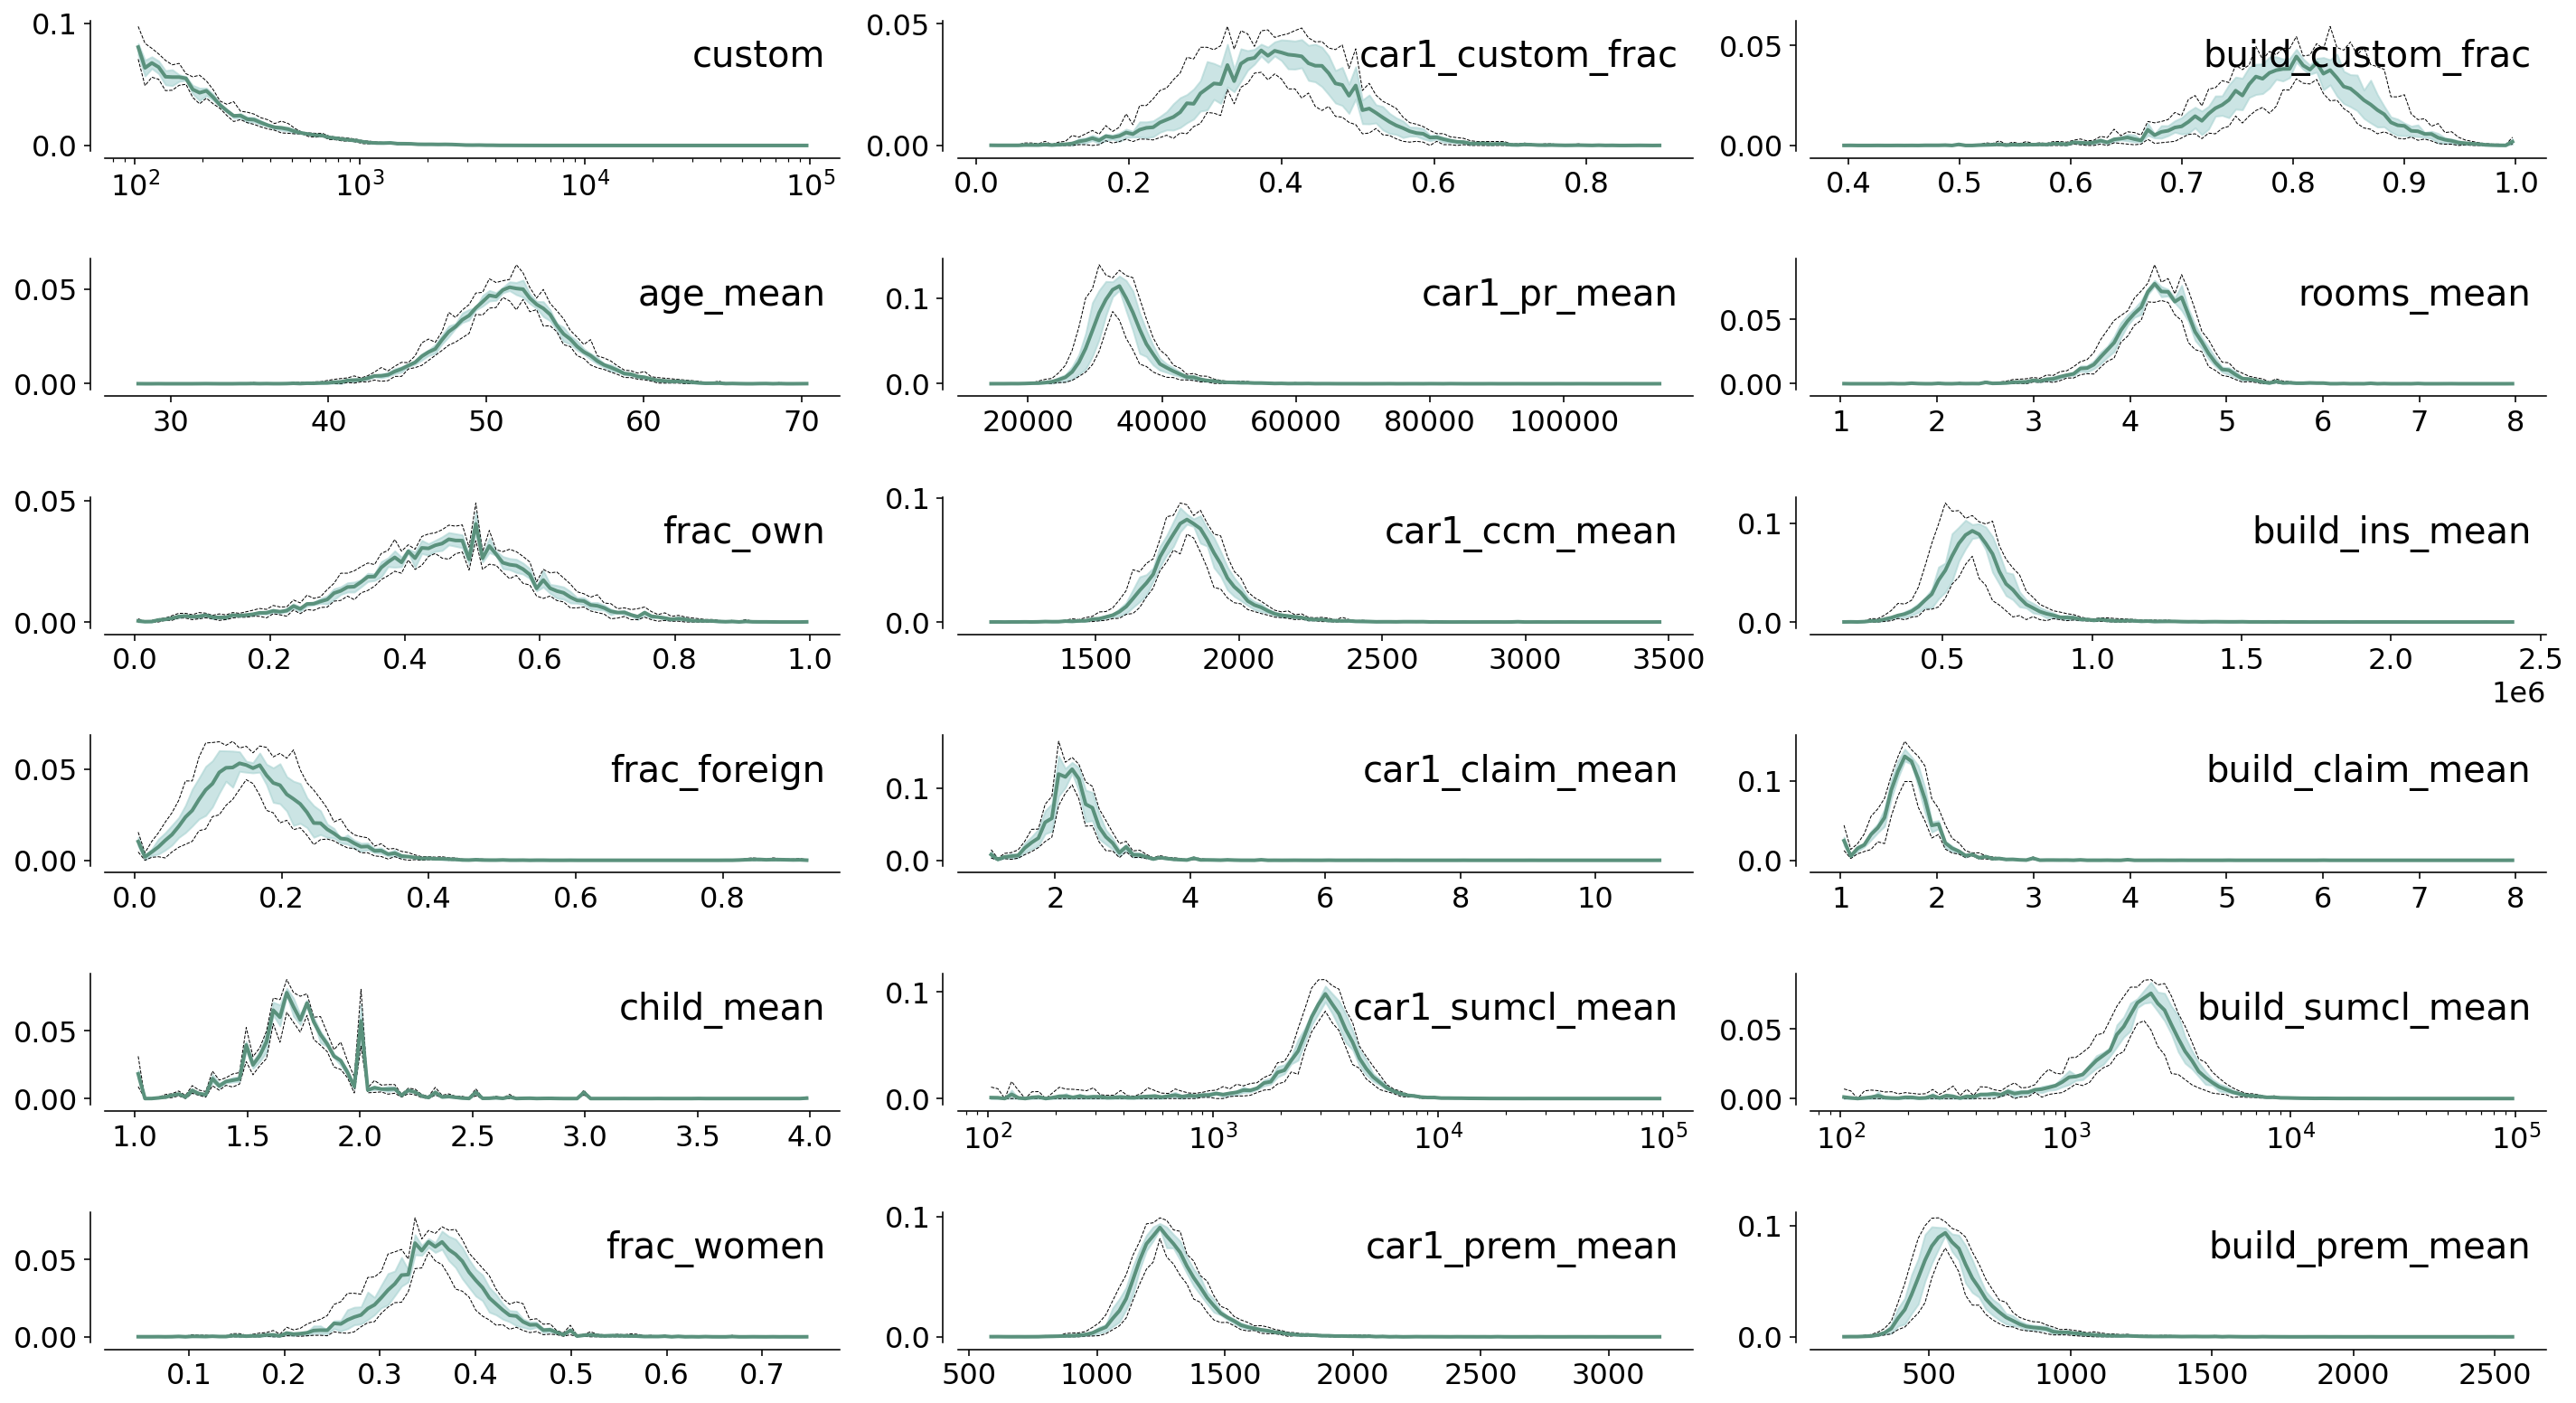

In [8]:
features_num={'custom':1, 'age_mean':4, 'frac_own':7, 'frac_foreign':10, 'child_mean':13, 'frac_women':16, 
         'car1_custom_frac':2,'car1_pr_mean':5,  'car1_ccm_mean':8, 'car1_claim_mean':11, 'car1_sumcl_mean':14, 'car1_prem_mean':17,
        'build_custom_frac':3,'rooms_mean':6, 'build_ins_mean':9,  'build_claim_mean':12, 'build_sumcl_mean':15, 'build_prem_mean':18}

features_pos={'custom':0.70, 'age_mean':0.70, 'frac_own':0.70, 'frac_foreign':0.70, 'child_mean':0.70, 'frac_women':0.68, 
         'car1_custom_frac':0.55, 'car1_pr_mean':0.60,  'car1_ccm_mean':0.60, 'car1_claim_mean':0.55, 'car1_sumcl_mean':0.50, 'car1_prem_mean':0.50,
     'build_custom_frac':0.55, 'rooms_mean':0.60,'build_ins_mean':0.55,  'build_claim_mean':0.55, 'build_sumcl_mean':0.53, 'build_prem_mean':0.55}


fig=plt.figure(figsize=(20,11))
for feature in features_num.keys():
    unity_density_all=[]
    ax=plt.subplot(6,3,features_num[feature])
    density_all_years, bins_all_years = np.histogram(combined[feature], bins=100,normed=True,density=True)
    if feature in ['custom','car1_sumcl_mean','build_sumcl_mean']:
        bins_all_years=np.logspace(2,5,100)
        ax.set_xscale('log')
    center = (bins_all_years[:-1] + bins_all_years[1:]) / 2
    for i in years:
        tmp=combined[combined['year']==i]
        density, bins = np.histogram(tmp[feature], bins=bins_all_years, normed=True,density=True)
        unity_density = density / density.sum()
        unity_density_all.append(unity_density)
    plt.annotate(feature, xy=(0.98, 0.65), ha='right', xycoords='axes fraction', size=20)
    unity_density_all=np.array(unity_density_all)  
    mean_for_plot=unity_density_all.mean(axis=0)
    pct25_for_plot=np.percentile(unity_density_all, 25, axis=0)
    pct75_for_plot=np.percentile(unity_density_all, 75, axis=0)
    min_for_plot=np.percentile(unity_density_all, 0, axis=0)
    max_for_plot=np.percentile(unity_density_all, 100, axis=0)
    ax.plot(center, mean_for_plot, color=colors[4], zorder=2, lw=2)
    ax.fill_between(center, pct75_for_plot, pct25_for_plot, color=colors[2], alpha=0.6, zorder=0)
    ax.plot(center, min_for_plot, color='black', linestyle='--', zorder=1, lw=0.5)
    ax.plot(center, max_for_plot, color='black', linestyle='--', zorder=1, lw=0.5)

    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('axes', -0.02))
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
plt.tight_layout()
fig.savefig('../Figures/Pre-processing/VariablesOverview.png',dpi=300,bbox_inches='tight')

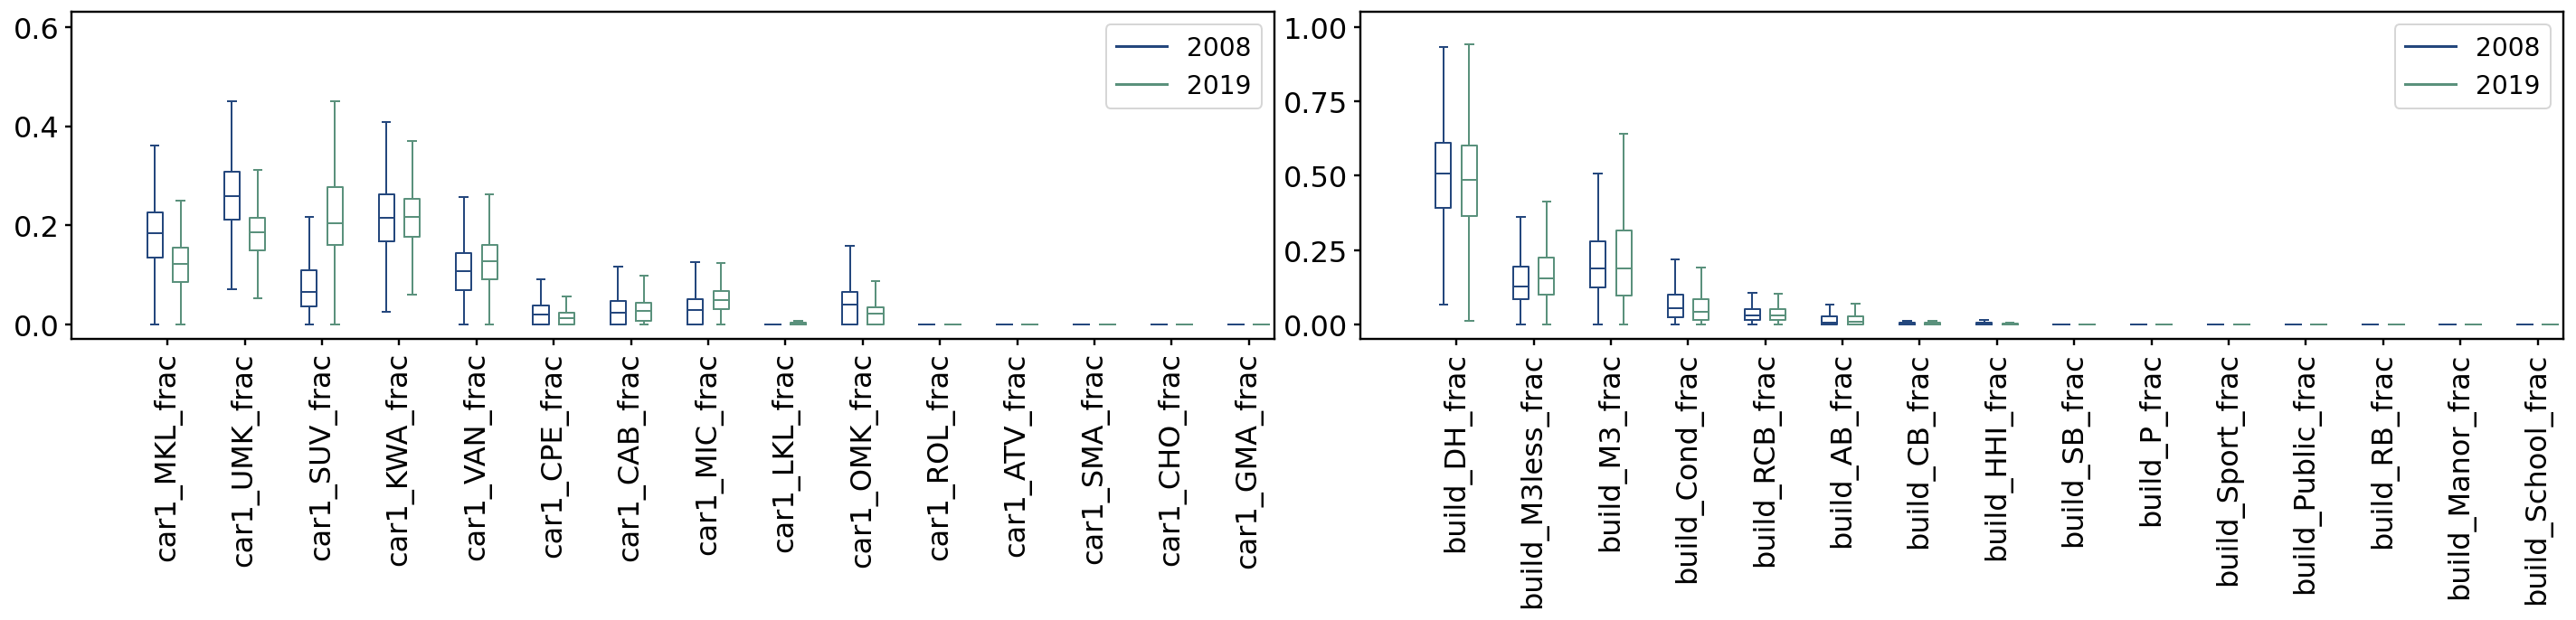

In [9]:
#Plot for class of cars and type of building [Two years only - 2008/2019]
car_classes=['car1_MKL_frac',
       'car1_UMK_frac', 'car1_SUV_frac', 'car1_KWA_frac', 'car1_VAN_frac',
       'car1_CPE_frac', 'car1_CAB_frac', 'car1_MIC_frac', 'car1_LKL_frac',
       'car1_OMK_frac', 'car1_ROL_frac', 'car1_ATV_frac', 'car1_SMA_frac', 'car1_CHO_frac', 'car1_GMA_frac'  ]

building_type=['build_DH_frac', 'build_M3less_frac', 'build_M3_frac',
       'build_Cond_frac', 'build_RCB_frac', 'build_AB_frac', 'build_CB_frac',
       'build_HHI_frac', 'build_SB_frac', 'build_P_frac', 'build_Sport_frac',
       'build_Public_frac', 'build_RB_frac', 'build_Manor_frac',
       'build_School_frac']

def setBoxColors(bp):
    setp(bp['boxes'][0], color=colors[3])
    setp(bp['caps'][0], color=colors[3])
    setp(bp['caps'][1], color=colors[3])
    setp(bp['whiskers'][0], color=colors[3])
    setp(bp['whiskers'][1], color=colors[3])
    setp(bp['medians'][0], color=colors[3])

    setp(bp['boxes'][1], color=colors[4])
    setp(bp['caps'][2], color=colors[4])
    setp(bp['caps'][3], color=colors[4])
    setp(bp['whiskers'][2], color=colors[4])
    setp(bp['whiskers'][3], color=colors[4])
    setp(bp['medians'][1], color=colors[4])

combined.fillna(0)
ticks=[]
fig=plt.figure(figsize=(20,5))
ax=plt.subplot(1,2,1)
for ind,feature in enumerate(car_classes):
    ind=ind*3
    ticks.append(ind+1.5)
    bp=ax.boxplot([combined[combined.year==2008][feature], combined[combined.year==2019][feature]], 
               positions=[ind+1,ind+2], widths=0.6,
               showfliers=False)
    setBoxColors(bp)

h08, = plot([0.6,0.6],colors[3])
h19, = plot([0.6,0.6],colors[4])
legend((h08, h19),('2008', '2019'))
h08.set_visible(False)
h19.set_visible(False)
ax.set_xticks(ticks)
ax.set_xticklabels(car_classes, rotation=90)
plt.tight_layout()

ticks=[]
ax=plt.subplot(1,2,2)
for ind,feature in enumerate(building_type):
    ind=ind*3
    ticks.append(ind+1.5)
    bp=ax.boxplot([combined[combined.year==2008][feature], combined[combined.year==2019][feature]], 
               positions=[ind+1,ind+2], widths=0.6,
               showfliers=False)
    setBoxColors(bp)

h08, = plot([1,1],colors[3])
h19, = plot([1,1],colors[4])
legend((h08, h19),('2008', '2019'))
h08.set_visible(False)
h19.set_visible(False)
ax.set_xticks(ticks)
ax.set_xticklabels(building_type, rotation=90)
plt.tight_layout()
fig.savefig('../Figures/Pre-processing/VariablesOverview_1.png',dpi=300,bbox_inches='tight')


In [10]:
#Check:
combined['check']=combined['car1_custom_frac']+combined['build_custom_frac']
combined['check'].describe()
#Min is 1 - correct

count    36352.000000
mean         1.188776
std          0.063872
min          1.000000
25%          1.146497
50%          1.183673
75%          1.226027
max          1.600000
Name: check, dtype: float64

## Technical validation

### Population

In [11]:
corrPop = []  ## Correlation population
corrFor = []  ## Correlation foreigners
pop = []      ## Population
pop_all = [] 
mS = []       ## Market Share
saveFiles = False
for i in range(2010, 2019, 1):
    dfAggregated = pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%i)
    dfAggregated=dfAggregated[dfAggregated.custom!=0]
    ## Population
    pc = pearcorr(dfAggregated.pop_census, dfAggregated.custom)[0]
    corrPop.append(pc)
    ## Foreigners
    pc = pearcorr(dfAggregated.frac_foreign_census, dfAggregated.frac_foreign)[0]
    corrFor.append(pc)
    pop.append(dfAggregated.pop_census.sum())
    pop_all.append(dfAggregated.pop_census)
    mS.append(dfAggregated.custom/dfAggregated.pop_census)

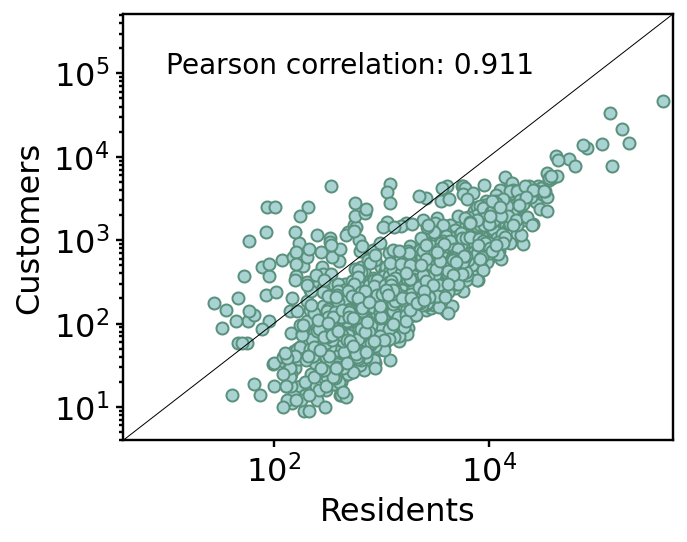

In [12]:
#Population - number of customer in 2018
f=plt.figure(figsize=(5,4))
ax=plt.subplot(1,1,1)
ax.scatter(dfAggregated.pop_census, dfAggregated.custom, color=colors[2], ec=colors[4]);
ax.axline((0,0), (max(dfAggregated.pop_census.max(),  dfAggregated.custom.max()), max(dfAggregated.pop_census.max(),  dfAggregated.custom.max())), color='black', linewidth=0.5);
ax.set_ylabel('Customers')
ax.set_xlabel('Residents')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([min(dfAggregated.pop_census.min()-5,  dfAggregated.custom.min()-5), max(dfAggregated.pop_census.max(),  dfAggregated.custom.max())+100000])
ax.set_ylim([min(dfAggregated.pop_census.min()-5,  dfAggregated.custom.min()-5), max(dfAggregated.pop_census.max(),  dfAggregated.custom.max())+100000])
ax.text(10, 100000 ,'Pearson correlation: %s'%round(pearcorr(dfAggregated.pop_census,  dfAggregated.custom)[0],3), fontsize=14 )
plt.tight_layout()
f.savefig('../Figures/Pre-processing/corrPop_2018.png',dpi=300,bbox_inches='tight')

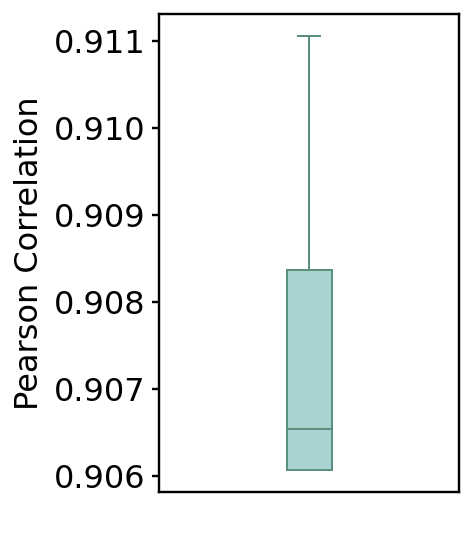

In [13]:
#Correlation over time
f=plt.figure(figsize=(3.5,4))
ax=plt.subplot(1,1,1)
ax.boxplot(corrPop, showfliers=False,patch_artist=True,
            boxprops=dict(facecolor=colors[2], color=colors[4]),
            capprops=dict(color=colors[4]),
            whiskerprops=dict(color=colors[4]),
            flierprops=dict(color=colors[2], markeredgecolor=colors[2]),
            medianprops=dict(color=colors[4]),
            );
ax.set_ylabel('Pearson Correlation')
ax.set_xlabel(' ')
ax.set_xticks([])
ax.set_xticklabels('')
plt.tight_layout()
f.savefig('../Figures/Pre-processing/corrPop_all.png',dpi=300,bbox_inches='tight')

In [14]:
m = []
for ind,i in enumerate(mS):
    m.append(np.average(i, weights=pop_all[ind])*100)

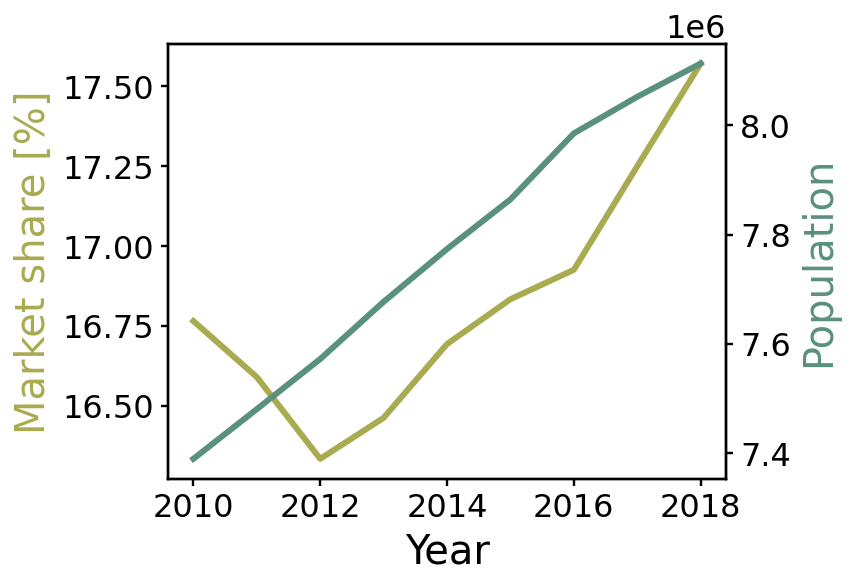

In [15]:
years=range(2010, 2019, 1)
f=plt.figure(figsize=(5,4))
ax=plt.subplot(1,1,1)
ax.plot(years, m, color=colors[0], label='Customers', linewidth=3)
ax2 = ax.twinx()
ax2.plot(years, pop, color=colors[4], label='Population', linewidth=3)
ax.set_ylabel('Market share [%]', color=colors[0], size=20)
ax2.set_ylabel('Population', color=colors[4], size=20)
ax.set_xlabel('Year', size=20)
ax.ticklabel_format(useOffset=False)
f.savefig('../Figures/Pre-processing/mSharePop.png',dpi=300,bbox_inches='tight')

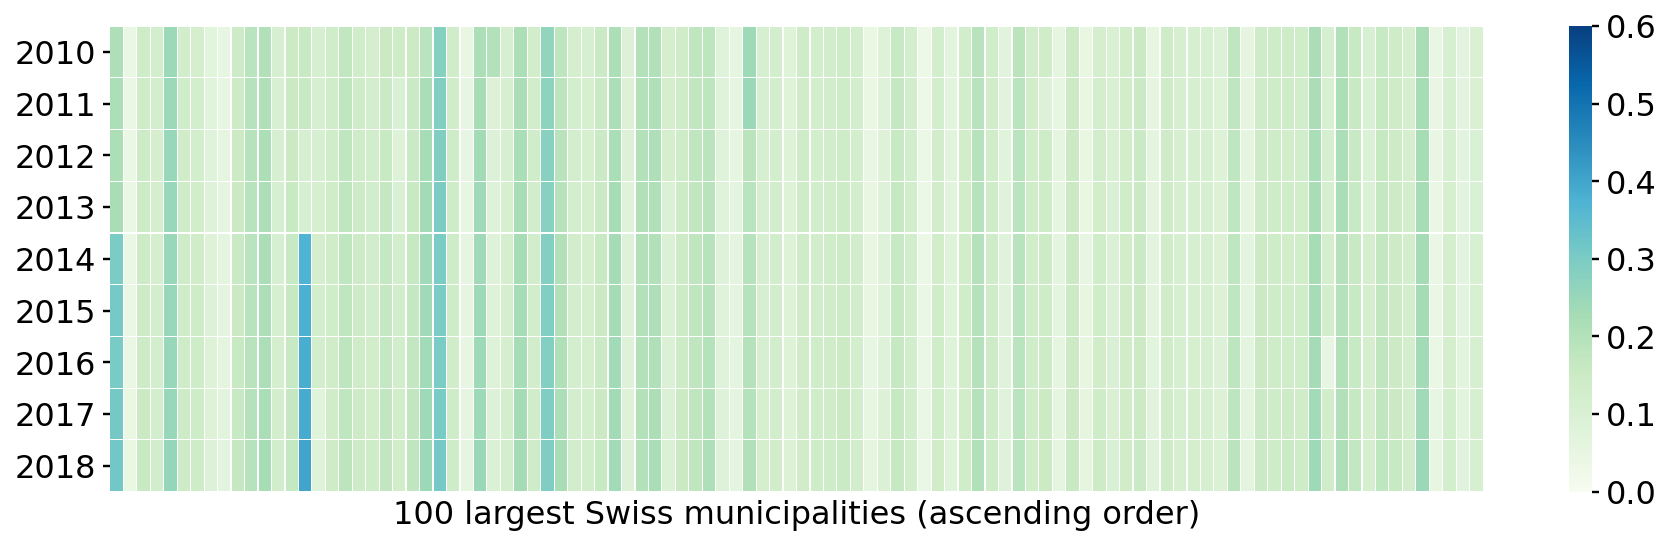

In [16]:
#Heatmap
for i in range(2010, 2019, 1):
    dfAggregated = pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%i)
    dfAggregated['year']=i
    if i==2010:
        all_years=dfAggregated.copy()
    else:
        all_years=all_years.append(dfAggregated)
all_years['ms']=all_years.apply(lambda x: x['custom']/x['pop_census'], axis=1)
all_years['idx']=all_years.groupby('BFS').cumcount()
all_years=all_years.fillna(0)
all_years=all_years.sort_values(['BFS', 'year'])
all_years_pivot=all_years.pivot(index='BFS',columns='idx')[['ms','pop_census']]
all_years_pivot=all_years_pivot.sort_values([('pop_census', 8)])
all_years_pivot=all_years_pivot.fillna(0)
all_years_for_map=all_years_pivot['ms'].values.T
np.shape(all_years_for_map[:,1993:])

f=plt.figure(figsize=(13,4))
ax=plt.subplot(1,1,1)
sns.heatmap(all_years_for_map[:,1993:], vmin=0, vmax=0.6,
            cmap='GnBu', linewidth=0.1)
ax.set_xlabel('100 largest Swiss municipalities (ascending order)')
ax.set_xticks([])
#ax.set_xticks([0.5, 99.5])
#ax.set_xticklabels(['mun  pop', 'mun  pop'])
ax.set_yticks(np.arange(0.5, 9.5, 1))
ax.set_yticklabels(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],rotation=0, ha='right')
plt.tight_layout()
f.savefig('../Figures/Pre-processing/mShareHeat.png',dpi=300,bbox_inches='tight')

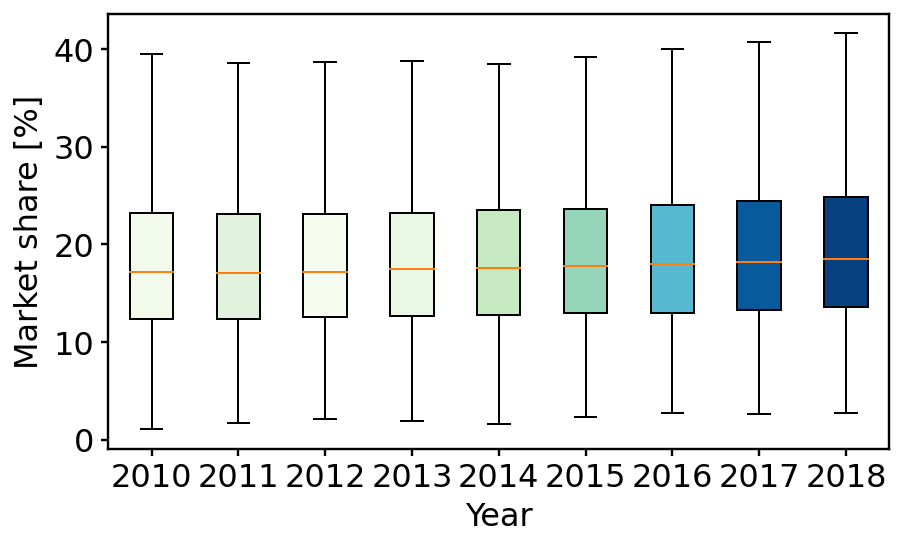

In [17]:
data = [mS[0]*100, mS[1]*100, mS[2]*100,mS[3]*100,mS[4]*100, mS[5]*100,mS[6]*100, mS[7]*100,mS[8]*100]  
f=plt.figure(figsize=(7,4))
ax=plt.subplot(1,1,1)
bplot=ax.boxplot(data, showfliers=False,patch_artist=True)
cmap = cm.ScalarMappable(cmap='GnBu')
test_mean = [np.mean(x) for x in data]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(test_mean)):
    patch.set_facecolor(color)

ax.set_ylabel('Market share [%]')
ax.set_xlabel('Year')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
f.savefig('../Figures/Pre-processing/Market_share_boxplots.png',dpi=300,bbox_inches='tight')        

### Percentage of foreigners

In [18]:
corrFor = []  ## Correlation foreigners
corrFor2 = []  ## Correlation foreigners (municipalities with more than 10000 residents)
corrFor1 = []  ## Correlation foreigners (municipalities with more than 100000 residents)
saveFiles = False
for i in years:
    dfAggregated = pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%i)
    dfAggregated=dfAggregated[dfAggregated.custom!=0]
    ## Foreigners
    pc = pearcorr(dfAggregated.frac_foreign_census, dfAggregated.frac_foreign)[0]
    corrFor.append(pc)  
    ## Foreigners (10,000 resid)
    tmp = dfAggregated[dfAggregated.pop_census > 10000]
    pc = pearcorr(tmp.frac_foreign_census, tmp.frac_foreign)[0]
    corrFor2.append(pc)
    ## Foreigners (100,000)
    tmp = dfAggregated[dfAggregated.pop_census > 100000]
    pc = pearcorr(tmp.frac_foreign_census, tmp.frac_foreign)[0]
    corrFor1.append(pc)  

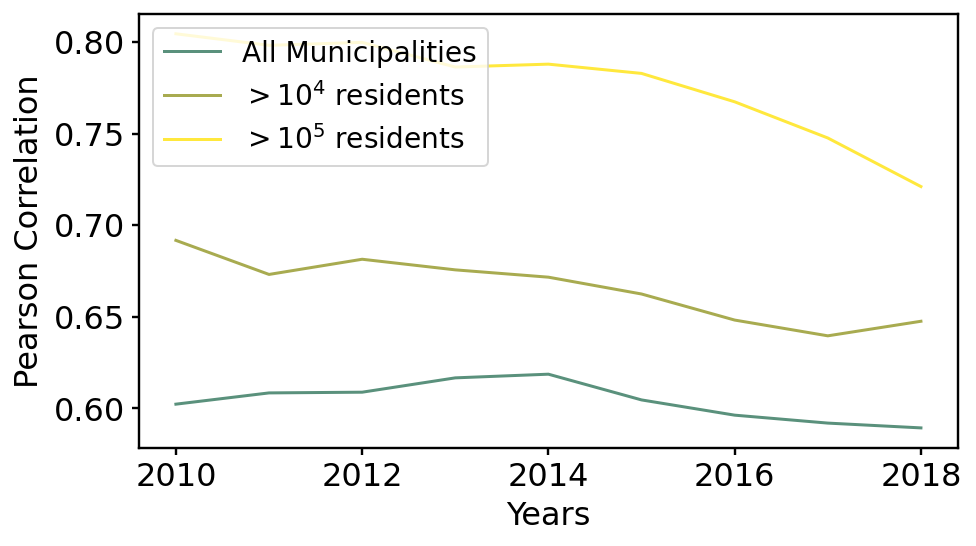

In [19]:
f,ax = plt.subplots(figsize=(7,4))
ax.plot(years, corrFor, label = 'All Municipalities', color=colors[4])
ax.plot(years, corrFor2, label = r'$> 10^4$'+' residents', color=colors[0])
ax.plot(years, corrFor1, label = r'$> 10^5$'+' residents', color=colors[1])
ax.set_ylabel('Pearson Correlation')
ax.set_xlabel('Years')
ax.legend(loc=2)
plt.tight_layout()
f.savefig('../Figures/Pre-processing/corrForeigners.pdf',dpi=300,bbox_inches='tight')

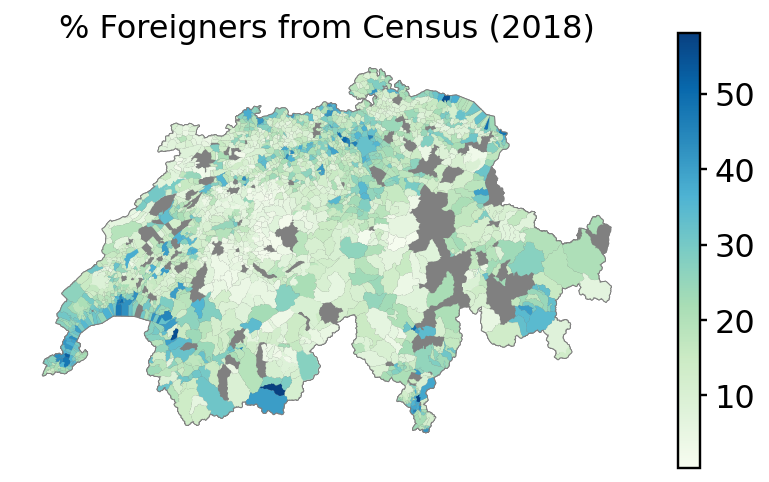

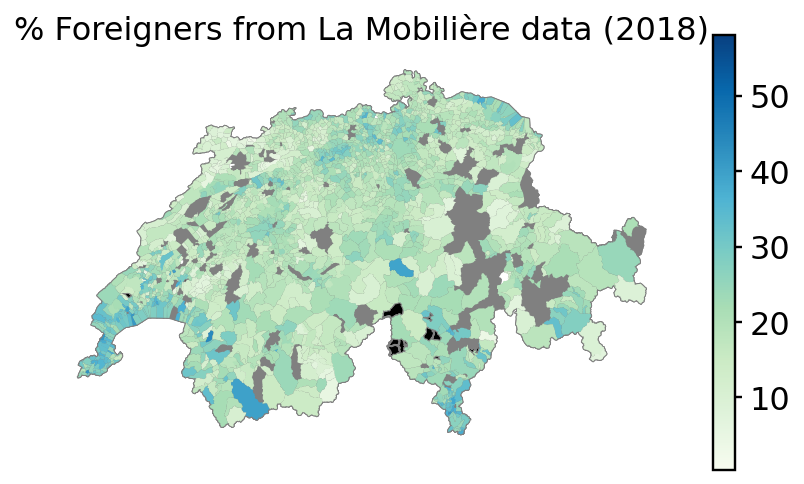

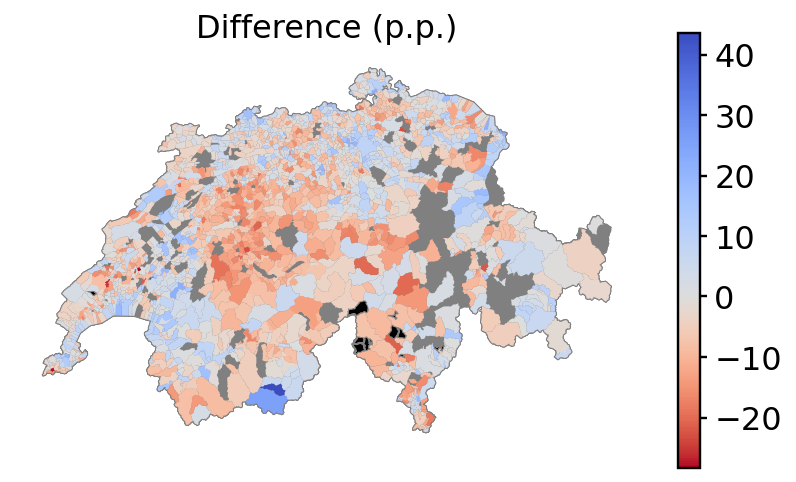

In [20]:
#Map for 2018
#% Foreigners in 2018
#Load shapefile
dfAggregated = pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%2018)
tmp_formap=pd.merge(munShape_2019[['BFS', 'geometry']], dfAggregated, on='BFS')
tmp_formap['f4_1']=tmp_formap['frac_foreign']*100 #Add very small positive value for log-normalisation of scale
unchanged_mun_formap=pd.merge(munShape_2019[['BFS', 'geometry']], dfAggregated, on='BFS')
f=plt.figure(figsize=(7,4))
ax=plt.subplot(1,1,1)
munShape_2019.plot(color='grey', ec='grey', ax=ax);
unchanged_mun_formap.plot(color='black', ec='grey', ax=ax);
tmp_formap.plot(column='frac_foreign_census', cmap='GnBu',vmin=min(tmp_formap['frac_foreign_census'].min(), tmp_formap[tmp_formap['f4_1']!=0].f4_1.min()), vmax=max(tmp_formap[tmp_formap['f4_1']!=0].f4_1.max(), tmp_formap['frac_foreign_census'].max()), ax=ax, legend=True);
ax.set_title('% Foreigners from Census (2018)')
ax.axis('off')
f.savefig('../Figures/Pre-processing/foreCensus_map_2018.png',dpi=300,bbox_inches='tight')
f=plt.figure(figsize=(7,4))
ax=plt.subplot(1,1,1)
munShape_2019.plot(color='grey', ec='grey', ax=ax);
unchanged_mun_formap.plot(color='black', ec='grey', ax=ax);
tmp_formap[tmp_formap['f4_1']==0].plot( color='white', ax=ax);
tmp_formap[tmp_formap['f4_1']!=0].plot(column='f4_1', cmap='GnBu' , vmin=min(tmp_formap['frac_foreign_census'].min(), tmp_formap[tmp_formap['f4_1']!=0].f4_1.min()), vmax=max(tmp_formap[tmp_formap['f4_1']!=0].f4_1.max(),tmp_formap['frac_foreign_census'].max()),ax=ax, legend=True);
ax.set_title('% Foreigners from La Mobilière data (2018)')
ax.axis('off')
f.savefig('../Figures/Pre-processing/foreInsure_map_2018.png',dpi=300,bbox_inches='tight')

#Difference plot
tmp_formap['diff']=tmp_formap['frac_foreign_census']-tmp_formap['f4_1']
f=plt.figure(figsize=(7,4))
ax=plt.subplot(1,1,1)
munShape_2019.plot(color='grey', ec='grey', ax=ax);
unchanged_mun_formap.plot(color='black', ec='grey', ax=ax);
tmp_formap.plot(column='diff', cmap='coolwarm_r', norm=matplotlib.colors.DivergingNorm(vmin=tmp_formap['diff'].min(), vcenter=0, vmax=tmp_formap['diff'].max()) ,ax=ax, legend=True);
ax.set_title('Difference (p.p.)')
ax.axis('off')
f.savefig('../Figures/Pre-processing/DiffFore_map_2018.png',dpi=300,bbox_inches='tight')

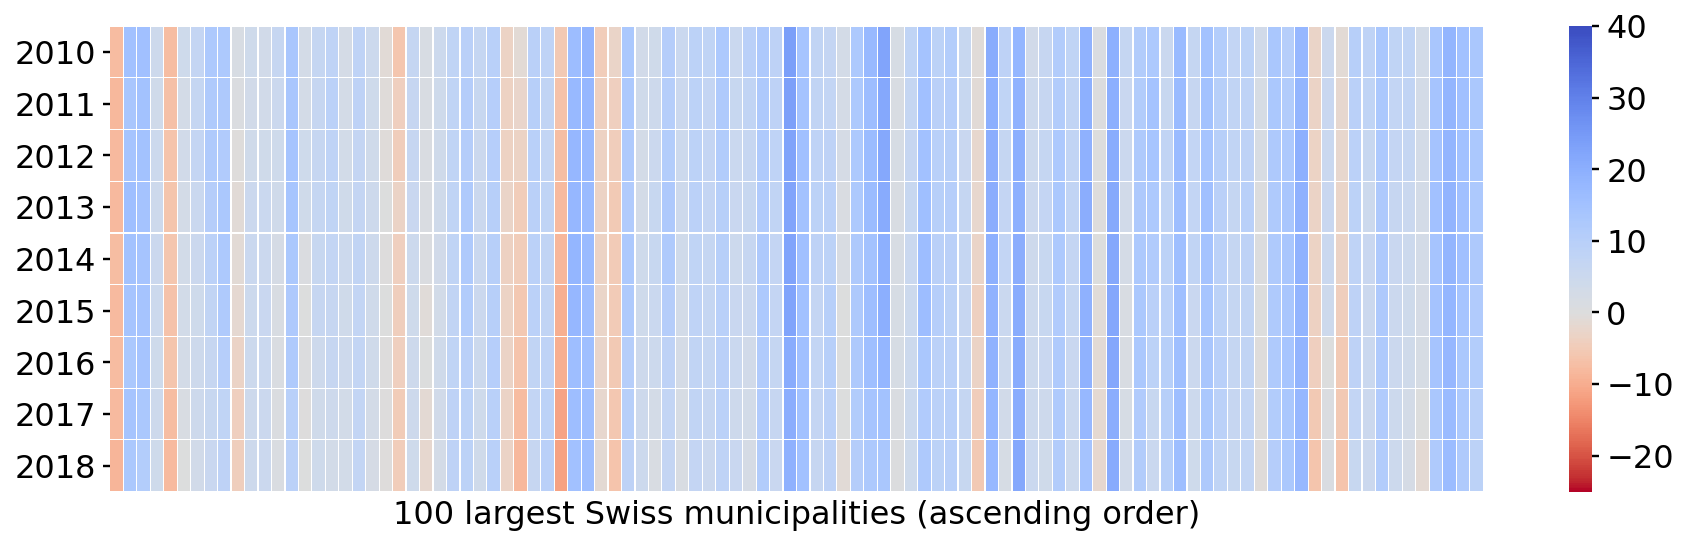

In [21]:
#Heatmap
for i in range(2010, 2019, 1):
    dfAggregated = pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%i)
    dfAggregated['year']=i
    if i==2010:
        all_years=dfAggregated.copy()
    else:
        all_years=all_years.append(dfAggregated)
all_years['ms']=all_years.apply(lambda x: x['frac_foreign_census']-x['frac_foreign']*100, axis=1)
all_years['idx']=all_years.groupby('BFS').cumcount()
all_years=all_years.fillna(0)
all_years=all_years.sort_values(['BFS', 'year'])
all_years_pivot=all_years.pivot(index='BFS',columns='idx')[['ms','pop_census']]
all_years_pivot=all_years_pivot.sort_values([('pop_census', 8)])
all_years_pivot=all_years_pivot.fillna(0)
all_years_for_map=all_years_pivot['ms'].values.T
np.shape(all_years_for_map[:,1993:])

f=plt.figure(figsize=(13,4))
ax=plt.subplot(1,1,1)
sns.heatmap(all_years_for_map[:,1993:],
            cmap='coolwarm_r', norm=matplotlib.colors.TwoSlopeNorm(vmin=-25, vcenter=0., vmax=40), linewidth=0.1)
ax.set_xlabel('100 largest Swiss municipalities (ascending order)')
ax.set_xticks([])
#ax.set_xticks([0.5, 99.5])
#ax.set_xticklabels(['mun  pop', 'mun  pop'])
ax.set_yticks(np.arange(0.5, 9.5, 1))
ax.set_yticklabels(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],rotation=0, ha='right')
plt.tight_layout()
f.savefig('../Figures/Pre-processing/foreignDiffHeat.png',dpi=300,bbox_inches='tight')

### Age

In [22]:
years = np.arange(2010, 2019, 1)

In [23]:
corrAge019 = []
corrAge2064 = []
corrAge64 = []
for i in years:
    dfAggregated =pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%i)
    dfAggregated=dfAggregated[dfAggregated.custom!=0]
    dfAge = pd.read_csv('../Data/ageData/ages_%d.csv'%i)
    tmp = pd.merge(dfAggregated, dfAge, on = 'BFS')
    pc = pearcorr(tmp['Age 0-19'], tmp['age_0_19_census'])[0]
    corrAge019.append(pc)
    pc = pearcorr(tmp['Age 20-64'], tmp['age_20_64_census'])[0]
    corrAge2064.append(pc)
    pc = pearcorr(tmp['Age >64'], tmp['age_65+_census'])[0]
    corrAge64.append(pc)

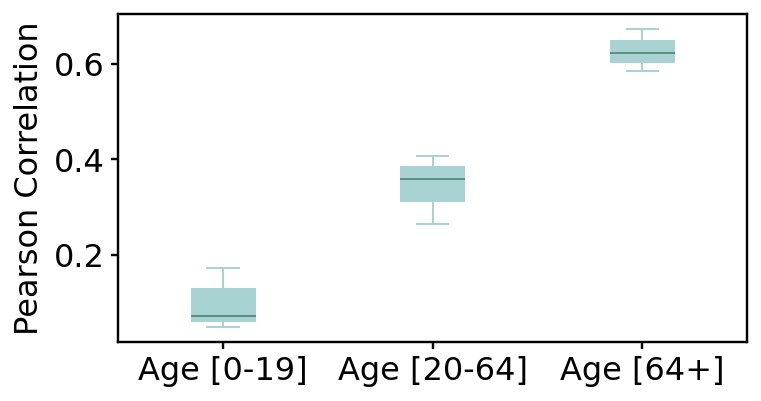

In [24]:
f,ax = plt.subplots(figsize=(5.5,3))
ax.boxplot([corrAge019, corrAge2064, corrAge64],showfliers=False,patch_artist=True,
            boxprops=dict(facecolor=colors[2], color=colors[2]),
            capprops=dict(color=colors[2]),
            whiskerprops=dict(color=colors[2]),
            flierprops=dict(color=colors[2], markeredgecolor=colors[2]),
            medianprops=dict(color=colors[4]));
ax.set_xticklabels(['Age [0-19]', 'Age [20-64]', 'Age [64+]']);
ax.set_ylabel('Pearson Correlation')
#ax.set_title('All municipalities')
plt.tight_layout()
f.savefig('../Figures/Pre-processing/corrAges.pdf',dpi=300,bbox_inches='tight')

In [25]:
## Big cities
corrAge019 = []
corrAge2064 = []
corrAge64 = []
for i in years:
    dfAggregated =pd.read_csv('../Data/combinedData/municipality_combinedData_%d.csv'%i)
    dfAggregated=dfAggregated[dfAggregated.custom.isnull()==False]
    dfAge = pd.read_csv('../Data/ageData/ages_%d.csv'%i)
    tmp = pd.merge(dfAggregated, dfAge, on = 'BFS')
    tmp = tmp[tmp.pop_census > 10000]
    pc = pearcorr(tmp['Age 0-19'], tmp['age_0_19_census'])[0]
    corrAge019.append(pc)
    pc = pearcorr(tmp['Age 20-64'], tmp['age_20_64_census'])[0]
    corrAge2064.append(pc)
    pc = pearcorr(tmp['Age >64'], tmp['age_65+_census'])[0]
    corrAge64.append(pc)

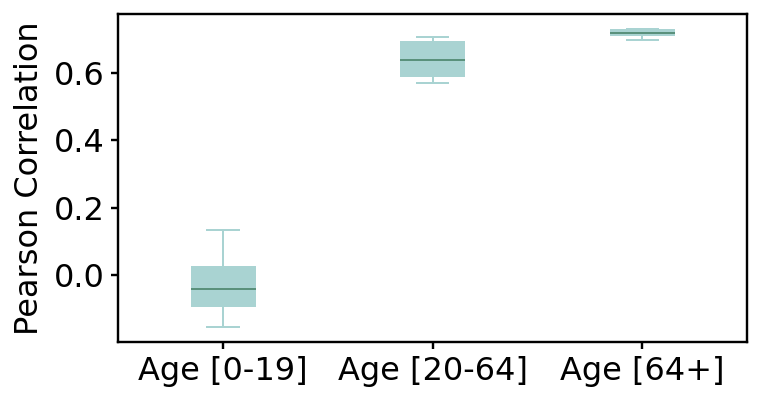

In [26]:
f,ax = plt.subplots(figsize=(5.5,3))
ax.boxplot([corrAge019, corrAge2064, corrAge64],showfliers=False,patch_artist=True,
            boxprops=dict(facecolor=colors[2], color=colors[2]),
            capprops=dict(color=colors[2]),
            whiskerprops=dict(color=colors[2]),
            flierprops=dict(color=colors[2], markeredgecolor=colors[2]),
            medianprops=dict(color=colors[4]));
ax.set_xticklabels(['Age [0-19]', 'Age [20-64]', 'Age [64+]']);
ax.set_ylabel('Pearson Correlation')
#ax.set_title('Municipalities with more than 10,000 res.')
plt.tight_layout()
f.savefig('../Figures/Pre-processing/corrAges10000.pdf',dpi=300,bbox_inches='tight')

##  Validation at ZIP code level

In [27]:
#Data processing:
df=gpd.read_file('../Data/ZIP-code_validation/Swiss_Quarters/shp/quart17.shp') #(https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/administrative-boundaries/boundaries-urban-quarters-swiss-cities.html)
df.rename(columns={'GMDEQNR': 'geo_id'}, inplace=True)
print(df.crs)

#import shapefile for zip codes
zipShape = gpd.read_file("../Data/shapeFiles/zips.shp")
zipShape['area_zip_int']=zipShape.to_crs('epsg:2056').geometry.area
zipShape.rename(columns={'PLZ': 'ZIP'}, inplace=True)
#keep only postal code starting with 80 (zurich area)
zipShape['zurich']=zipShape.apply(lambda x: 1 if str(x['ZIP'])[0:2]=='80' else 0, axis=1)
print(zipShape.crs)

#Import data at district level
house=pd.read_excel('../Data/ZIP-code_validation/City Statistics - data/Single_lodgement_per100k_%d.xlsx'%2019,engine='openpyxl', header=None)   #2019 data
house=house[(house.index>4) & (house.index<234)]
house.rename(columns={0: 'geo_id', 1:'name', 2:'Single_lodgement_per100k'}, inplace=True)
house['geo_id']=house['geo_id'].astype('int')
house=pd.merge(df[['geo_id', 'geometry']], house, on='geo_id', how='inner')
house=gpd.GeoDataFrame(house, crs=df.crs, geometry='geometry')
house.to_crs('epsg:4326', inplace=True)
house['area_quartier_int']=house.to_crs('epsg:2056').geometry.area
print(house.crs)


foreigners=pd.read_excel('../Data/ZIP-code_validation/City Statistics - data/Foreigners_%d.xlsx'%2019,engine='openpyxl', header=None)   #2019 data
foreigners=foreigners[(foreigners.index>4) & (foreigners.index<234)]
foreigners.rename(columns={0: 'geo_id', 1:'name', 2:'foreigners'}, inplace=True)
foreigners['geo_id']=foreigners['geo_id'].astype('int')

age=pd.read_excel('../Data/ZIP-code_validation/City Statistics - data/Median_age_%d.xlsx'%2019,engine='openpyxl', header=None)   #2019 data
age=age[(age.index>4) & (age.index<234)]
age.rename(columns={0: 'geo_id', 1:'name', 2:'median_age'}, inplace=True)
age['geo_id']=age['geo_id'].astype('int')

house=pd.merge(house, foreigners[['geo_id', 'foreigners']], on='geo_id', how='inner')
house=pd.merge(house, age[['geo_id', 'median_age']], on='geo_id', how='inner')
#Keep only neighbourhood with complete info
house['to_drop']=house.apply(lambda x: 1 if (x['foreigners']=='–') |(x['median_age']=='–') else 0, axis=1)
house=house[house['to_drop']==0]

combined_zip=gpd.overlay(house,zipShape, how='intersection')
combined_zip['area_int']=combined_zip.to_crs('epsg:2056').geometry.area
#Drop if the sum of intersection area is small (less than 5% or the ZIP code)
tmp1=combined_zip[['ZIP','area_zip_int', 'geometry']].dissolve('ZIP')
tmp1['area_diss']=tmp1.to_crs('epsg:2056').geometry.area
tmp1['area_diss_prop']=tmp1.apply(lambda x: x['area_diss']/x['area_zip_int']*100,axis=1)
tmp1=tmp1[(tmp1[ 'area_diss_prop']>30)].reset_index()
combined_zip=pd.merge(combined_zip, tmp1, on='ZIP')
combined_zip['area_int_zip_perc']=combined_zip.apply(lambda x: x['area_int']/x['area_diss']*100,axis=1) #compute weights (as denominator use dissolved areas (area of all intersetions))

#select mean features only and compute average features
mean_features=['Single_lodgement_per100k', 'foreigners', 'median_age']


def weighted_av(x, name,feature, weight):
    names = {name: (x[weight] * x[feature]).sum()/x[weight].sum()}
    return pd.Series(names, index=[name])

for ind,i in enumerate(mean_features):
    combined_zip[i]=combined_zip[i].astype('float')
    tmp=combined_zip.groupby(["ZIP"]).apply(lambda x: weighted_av(x,i, i,'area_int_zip_perc'))
    if ind==0:
        insurance_2019_zip=tmp.copy()
    else:
        insurance_2019_zip=pd.merge(insurance_2019_zip,tmp, on='ZIP', how='inner')

insurance_2019_zip=pd.merge(insurance_2019_zip, zipShape[['ZIP','geometry']], on='ZIP', how='inner')
insurance_2019=pd.read_csv("../Data/aggregatedData/ZIP_2019.csv")
insurance_2019_zip=pd.merge(insurance_2019_zip, insurance_2019, on='ZIP', how='inner')

insurance_2019_zip=gpd.GeoDataFrame(insurance_2019_zip,geometry='geometry', crs=house.crs)

#Manually drop two ZIP codes with low intersection but not previously detected
insurance_2019_zip=insurance_2019_zip[(insurance_2019_zip.index!=51 )& (insurance_2019_zip.index!=101 )& (insurance_2019_zip.index!=11 )]

epsg:2056
epsg:4326
epsg:4326


In [28]:
zip_mun={'60':'Lucerne', '12':'Geneve', '69':'Lugano', '80':'Zurich', '90':'St. Gallen', '10':'Lausanne', '30':'Bern', '84':'Winterthur', '40':'Basel'}
geo_mun={'10':'Lucerne', '66':'Geneve', '51':'Lugano', '26':'Zurich', '32':'St. Gallen', '55':'Lausanne', '35':'Bern', '23':'Winterthur', '27':'Basel'}

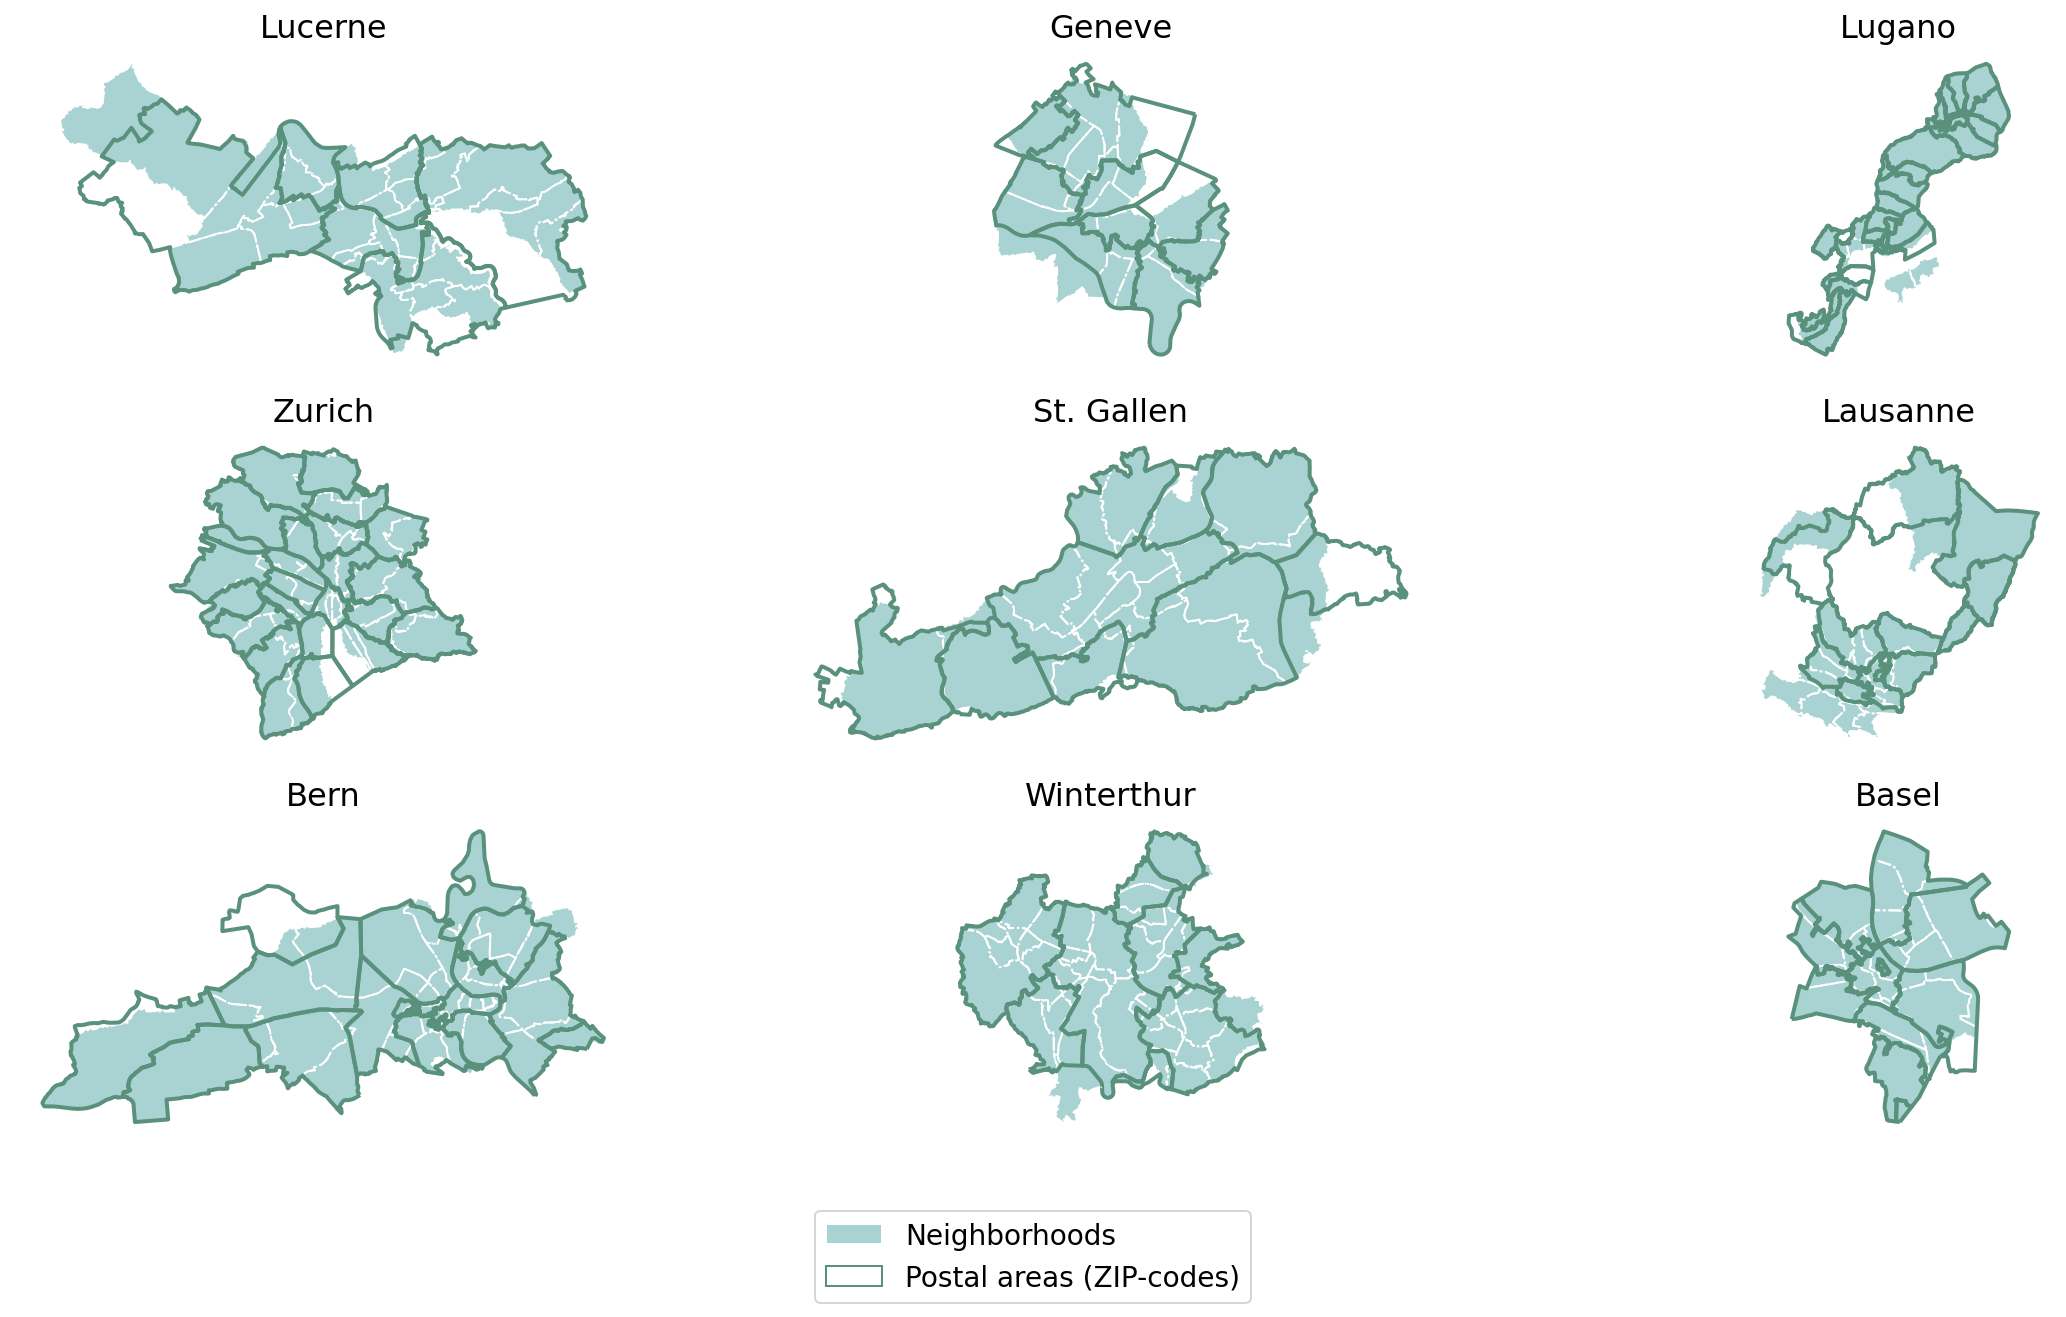

In [29]:
insurance_2019_zip['mun_z']=insurance_2019_zip.apply(lambda x: zip_mun[str(x['ZIP'])[0:2]] if str(x['ZIP'])[0:2] in list(zip_mun.keys()) else "", axis=1)
insurance_2019_zip['mun_z']=insurance_2019_zip.apply(lambda x: 'Winterthur' if str(x['ZIP'])[0:2]=='83' else x['mun_z'], axis=1)
insurance_2019_zip['mun_z']=insurance_2019_zip.apply(lambda x: 'Winterthur' if str(x['ZIP'])[0:2]=='85' else x['mun_z'], axis=1)
insurance_2019_zip['mun_z']=insurance_2019_zip.apply(lambda x: 'Bern' if str(x['ZIP'])[0:2]=='31' else x['mun_z'], axis=1)
insurance_2019_zip['mun_z']=insurance_2019_zip.apply(lambda x: 'Lugano' if str(x['ZIP'])[0:2]=='68' else x['mun_z'], axis=1)
insurance_2019_zip['mun_z']=insurance_2019_zip.apply(lambda x: zip_mun[str(x['ZIP'])[0:2]] if str(x['ZIP'])[0:2] in list(zip_mun.keys()) else "", axis=1)

house['mun_g']=house.apply(lambda x: geo_mun[str(x['geo_id'])[0:2]] if str(x['geo_id'])[0:2] in list(geo_mun.keys()) else "", axis=1)
fig=plt.figure(figsize=(20,10))
for ind,i in enumerate(list(zip_mun.values())):
    ax=plt.subplot(3,3,ind+1)
    house[house['mun_g']==i].boundary.plot(ax=ax, linewidth=1, color='white', ls='-.')
    house[house['mun_g']==i].plot(ax=ax, linewidth=1, color=colors[2], label='Neigh.')
    insurance_2019_zip[insurance_2019_zip['mun_z']==i].boundary.plot(ax=ax,linewidth=2, color=colors[4], label='ZIP')
    ax.axis('off')
    ax.set_title(i,)
LegendElement = [
                 mpatches.Patch(facecolor=colors[2], edgecolor='white', label='Neighborhoods'),
                 mpatches.Patch(facecolor='w', edgecolor=colors[4], label='Postal areas (ZIP-codes)')
                ]
fig.legend(handles = LegendElement,loc='lower center')
fig.savefig('../Figures/Pre-processing/maps.png',dpi=300,bbox_inches='tight')  

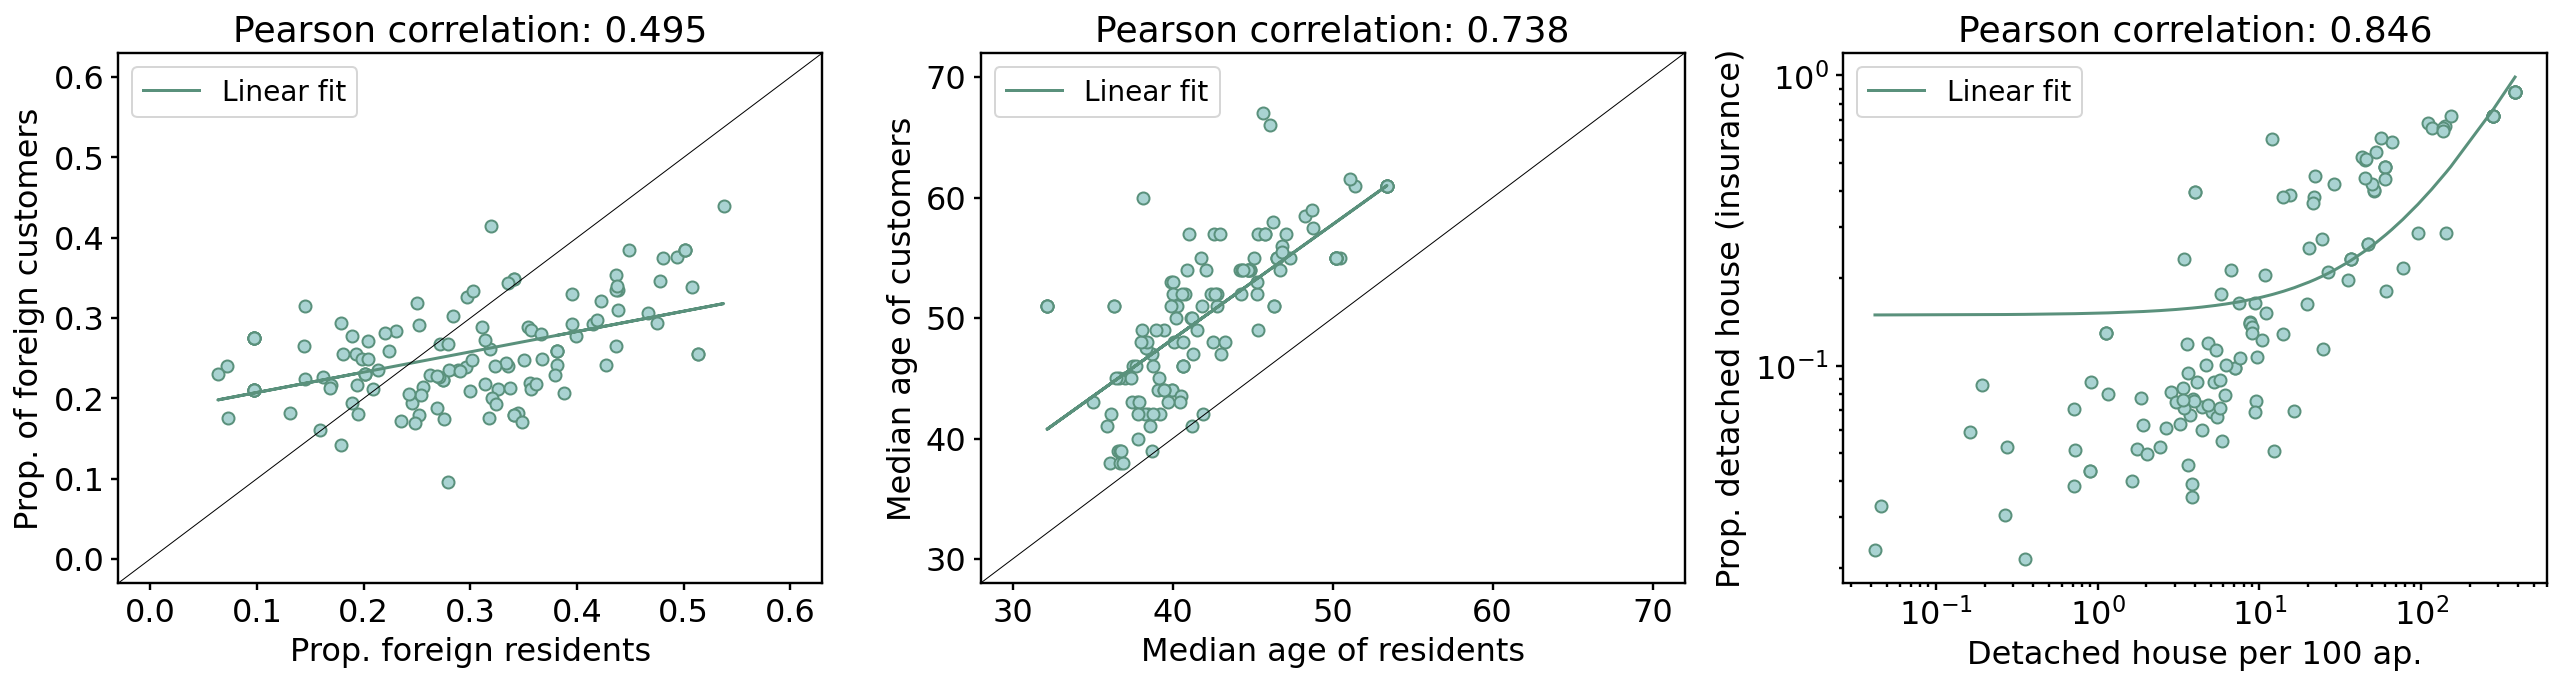

In [30]:
f=plt.figure(figsize=(18,5))
ax=plt.subplot(1,3,1)
m, b = polyfit(insurance_2019_zip.foreigners/100, insurance_2019_zip.frac_foreign, 1)
ax.scatter(insurance_2019_zip.foreigners/100, insurance_2019_zip.frac_foreign, color=colors[2], ec=colors[4]);
ax.plot(insurance_2019_zip.foreigners/100, b + m * insurance_2019_zip.foreigners/100, '-', color=colors[4], label='Linear fit')
ax.axline((0,0), (0.6,0.6), color='black', linewidth=0.5);
ax.set_ylabel('Prop. of foreign customers')
ax.set_xlabel('Prop. foreign residents')
ax.legend()
#ax.set_xlim([min(insurance_2019_zip.foreigners.min(),  insurance_2019_zip.frac_foreign.min()), max(insurance_2019_zip.foreigners.max(),  insurance_2019_zip.frac_foreign.max())])
#ax.set_ylim([min(insurance_2019_zip.foreigners.min(),  insurance_2019_zip.frac_foreign.min()), max(insurance_2019_zip.foreigners.max(),  insurance_2019_zip.frac_foreign.max())])
ax.set_title('Pearson correlation: %s'%round(pearcorr(insurance_2019_zip.foreigners/100,  insurance_2019_zip.frac_foreign)[0],3), fontsize=18 )
plt.tight_layout()

m1, b1 = polyfit(insurance_2019_zip.median_age, insurance_2019_zip.age_pct50, 1)
ax=plt.subplot(1,3,2)
ax.scatter(insurance_2019_zip.median_age, insurance_2019_zip.age_pct50, color=colors[2], ec=colors[4]);
ax.plot(insurance_2019_zip.median_age, b1 + m1 * insurance_2019_zip.median_age, '-', color=colors[4], label='Linear fit')
ax.axline((30,30), (70,70), color='black', linewidth=0.5);
ax.legend()
ax.set_ylabel('Median age of customers')
ax.set_xlabel('Median age of residents')
ax.set_title('Pearson correlation: %s'%round(pearcorr(insurance_2019_zip.median_age,  insurance_2019_zip.age_pct50)[0],3), fontsize=18 )
plt.tight_layout()

m2, b2 = polyfit(insurance_2019_zip.Single_lodgement_per100k, insurance_2019_zip.build_DH_frac, 1)
x=np.array(sorted(insurance_2019_zip.Single_lodgement_per100k))
ax=plt.subplot(1,3,3)
ax.scatter(insurance_2019_zip.Single_lodgement_per100k, insurance_2019_zip.build_DH_frac, color=colors[2], ec=colors[4]);
ax.plot(x, b2 + m2 * x, '-', color=colors[4], label='Linear fit')
ax.set_ylabel('Prop. detached house (insurance)')
ax.set_xlabel('Detached house per 100 ap.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
#ax.set_xlim([min(insurance_2019_zip.foreigners.min(),  insurance_2019_zip.frac_foreign.min()), max(insurance_2019_zip.foreigners.max(),  insurance_2019_zip.frac_foreign.max())])
#ax.set_ylim([min(insurance_2019_zip.foreigners.min(),  insurance_2019_zip.frac_foreign.min()), max(insurance_2019_zip.foreigners.max(),  insurance_2019_zip.frac_foreign.max())])
ax.set_title('Pearson correlation: %s'%round(pearcorr(insurance_2019_zip.Single_lodgement_per100k,  insurance_2019_zip.build_DH_frac)[0],3), fontsize=18 )
plt.tight_layout()
f.savefig('../Figures/Pre-processing/corrs_zip_2019.png',dpi=300,bbox_inches='tight')

## Focus on the municipality of Zurich:


In [31]:
insurance_2019_zip=insurance_2019_zip[insurance_2019_zip['mun_z']=='Zurich']

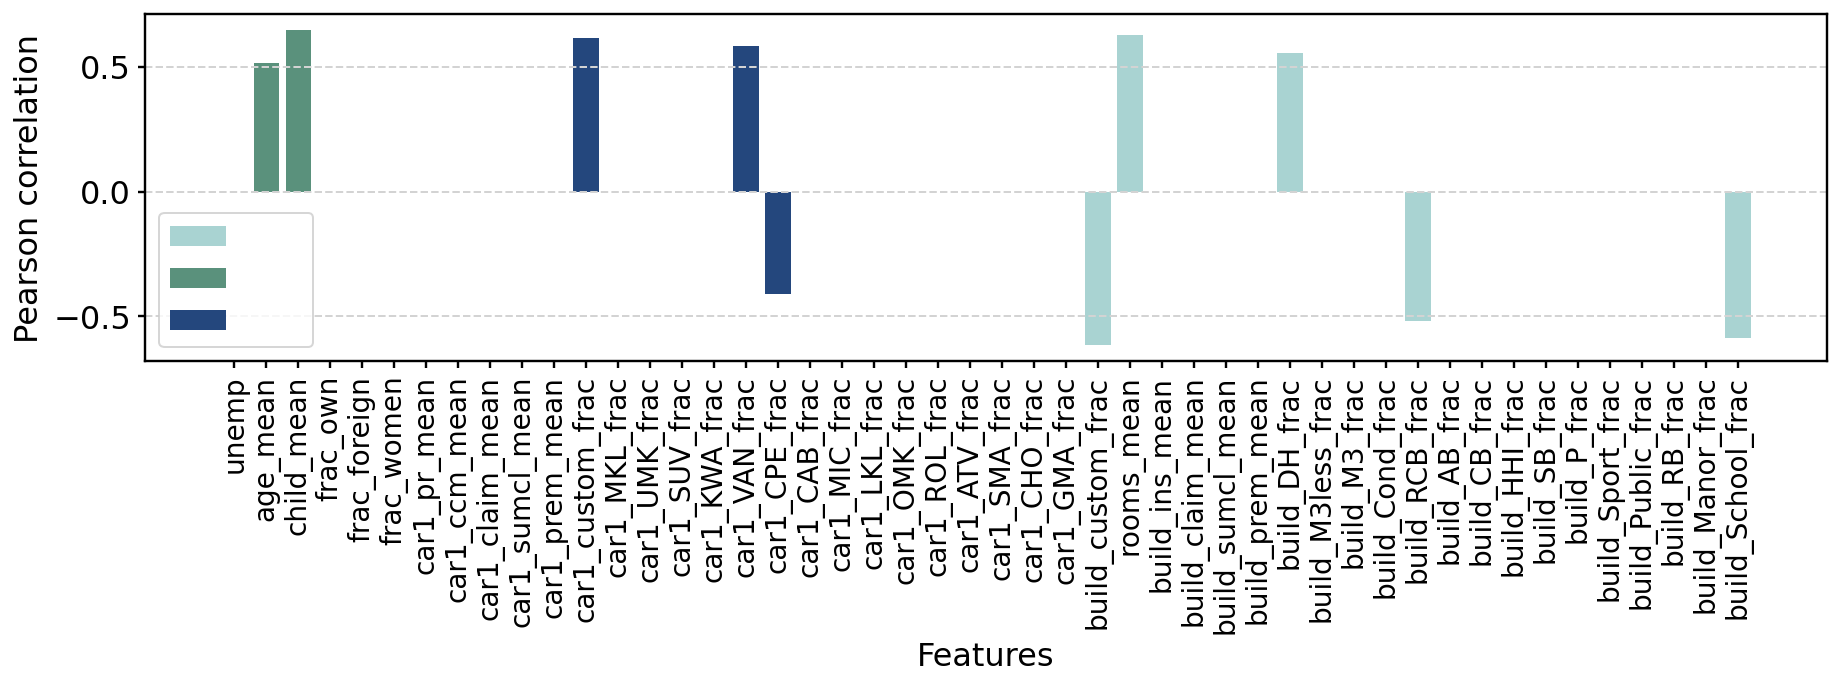

In [32]:
features=[ 'unemp', 'age_mean', 'child_mean', 'frac_own', 'frac_foreign',
       'frac_women', 'car1_pr_mean', 'car1_ccm_mean',
       'car1_claim_mean', 'car1_sumcl_mean', 'car1_prem_mean',
       'car1_custom_frac', 'car1_MKL_frac', 'car1_UMK_frac', 'car1_SUV_frac',
       'car1_KWA_frac', 'car1_VAN_frac', 'car1_CPE_frac', 'car1_CAB_frac',
       'car1_MIC_frac', 'car1_LKL_frac', 'car1_OMK_frac', 'car1_ROL_frac',
       'car1_ATV_frac', 'car1_SMA_frac', 'car1_CHO_frac', 'car1_GMA_frac', 'build_custom_frac', 'rooms_mean',
       'build_ins_mean', 'build_claim_mean',
       'build_sumcl_mean', 'build_prem_mean', 'build_DH_frac',
       'build_M3less_frac', 'build_M3_frac', 'build_Cond_frac',
       'build_RCB_frac', 'build_AB_frac', 'build_CB_frac', 'build_HHI_frac',
       'build_SB_frac', 'build_P_frac', 'build_Sport_frac',
       'build_Public_frac', 'build_RB_frac', 'build_Manor_frac',
       'build_School_frac']


#Explore correlations using correlation matrix
col=features.copy()
col.insert(0, 'Single_lodgement_log')
insurance_2019_zip['Single_lodgement_log']=np.log(insurance_2019_zip['Single_lodgement_per100k'])
data=insurance_2019_zip[col].copy()
correlation = np.corrcoef(data.values.T)[0]
#Compute pairwise pvalues and set to 0 if not statistically significant at 5%
for ind,i in enumerate(col):
    p_val=pearcorr(data[i], data['Single_lodgement_log'])[1]
    if p_val>0.05:
        correlation[ind]=0

f,ax = plt.subplots(figsize=(13,5))
ax.grid(b=True, which='major', axis='y', color='lightgrey', linestyle='--', linewidth=1)
ax.bar(col[1:],correlation[1:], color=colors[2], label='      ')
ax.bar(col[1:7],correlation[1:7], color=colors[4], label='      ')
ax.bar(col[7:28],correlation[7:28], color=colors[3], label='      ')
#ax.axhline(0.3, 0, 36, color='red', linewidth=0.3)
#ax.axhline(-0.3, 0, 36, color='red', linewidth=0.3)
ax.set_xlabel('Features')
ax.set_xticklabels(col[1:], rotation=90, fontsize=14)
ax.set_ylabel('Pearson correlation')
ax.legend()
plt.tight_layout()
f.savefig('../Figures/Pre-processing/ZIP_house_correlation_zurich.pdf',dpi=300,bbox_inches='tight')

Mean with best score:  -0.7140573260278701
Best estimator:  LassoLars(alpha=0.1, fit_intercept=False)
                                  OLS Regression Results                                 
Dep. Variable:     Single_lodgement_log   R-squared (uncentered):                   0.813
Model:                              OLS   Adj. R-squared (uncentered):              0.680
Method:                   Least Squares   F-statistic:                              3.643
Date:                  Mon, 14 Jun 2021   Prob (F-statistic):                      0.0139
Time:                          12:14:07   Log-Likelihood:                         -13.917
No. Observations:                    24   AIC:                                      47.83
Df Residuals:                        14   BIC:                                      59.61
Df Model:                            10                                                  
Covariance Type:                    HC1                                                 

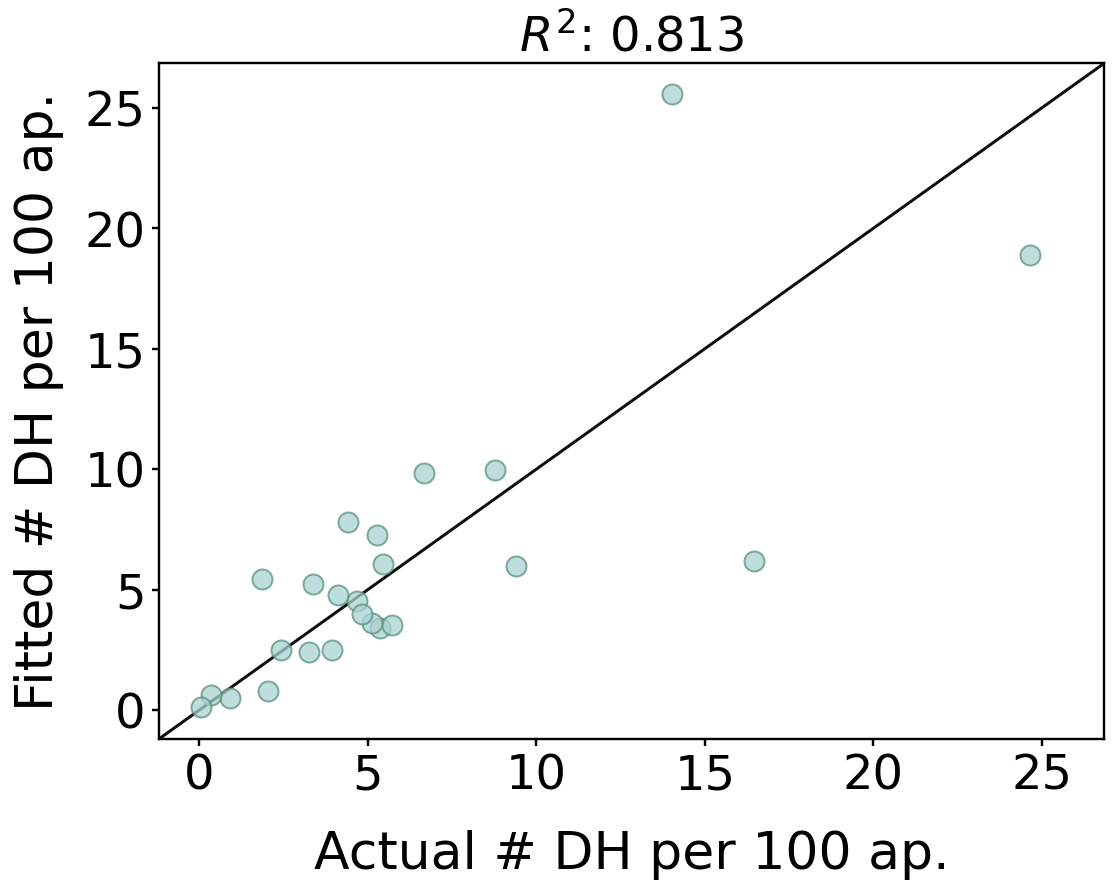

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLars
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#Standardize continuous input variables
scalerx = StandardScaler(with_std=True)
data[col[1:]]  = scalerx.fit_transform(data[col[1:]])

#Standardize target variables
scalery = StandardScaler(with_std=True)
data['Single_lodgement_log']  = scalery.fit_transform(data['Single_lodgement_log'].to_numpy().reshape(-1,1))
#Select relevant columns for prediction task
X = data[col[1:]]
y = data['Single_lodgement_log']

# searching for the best estimator
l_min = -1
l_max = 0
l_num = 1000
alphas = np.logspace(l_min, l_max, l_num)
params = {'alpha': alphas}
kf = KFold(n_splits=5, shuffle = False)
lasso_regressor = GridSearchCV(LassoLars(fit_intercept=False), params, scoring = 'neg_mean_squared_error', cv=kf)
lasso_regressor.fit(X, y)

# best estimator
print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_
lasso_best.fit(X,y)

# extract chosen determinants
coef = pd.Series(lasso_best.coef_, list(col[1:]))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_selected = coef[coef['Value']!=0]
selected_features=coef_selected.Coefficient.tolist()
selected_features

# final model with selected variables
X = data[selected_features]
y = data['Single_lodgement_log']

# final OLS regression
final = sm.OLS(y, X).fit(cov_type='HC1')
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

# inverse transformation of the data
y_pred_inversed = scalery.inverse_transform(final.predict(X))
y_pred_inversed

# inverse transformation of the data
y_inversed = scalery.inverse_transform(y)
y_inversed

# showing the results as a table
results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: selected_features[0], 2: selected_features[1] })
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

# showing the scatter plot
f=plt.figure(figsize=(8, 6.5))
ax=plt.subplot(1,1,1)
ax.scatter(np.exp(y_inversed), np.exp(y_pred_inversed), marker= 'o', s= 100, alpha= 0.75,color=colors[2]  ,ec=colors[4]  )
ax.set_xlabel('Actual # DH per 100 ap.', labelpad=15, size=26)
ax.set_ylabel('Fitted # DH per 100 ap.', labelpad=10, size=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
ax.set_title(r"$R^{2}$: %.3f"%final.rsquared, fontsize=24)
# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_facecolor('white')
#ax.grid(color='k', linestyle='-', linewidth=0.1)

#Stanrdardized residuls, plot distribution and map
influence = final.get_influence()
standardized_residuals = influence.resid_studentized_internal

plt.tight_layout()
f.savefig('../Figures/Pre-processing/Neighbourhoods_house_fitted_vs_actual_zurich.pdf',dpi=300,bbox_inches='tight')

-0.09155158363799565
0.365
-0.09155158363799565
0.373


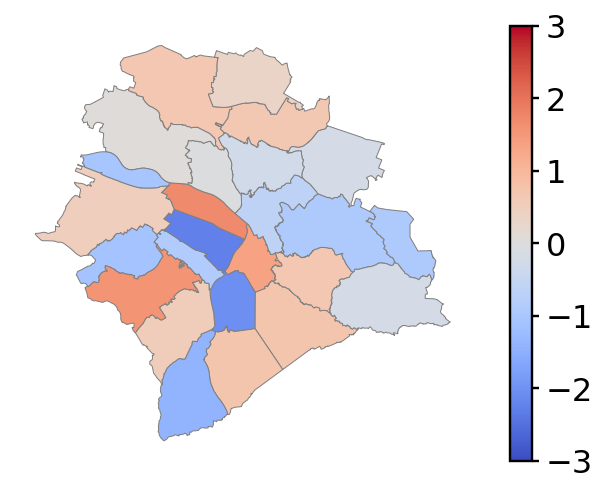

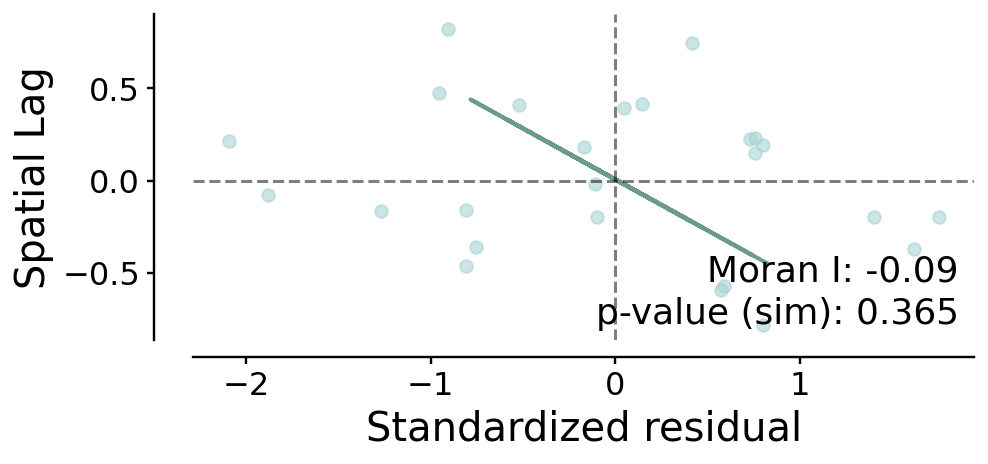

In [34]:
import geopandas
from esda.moran import Moran
from shapely.geometry import Polygon
from libpysal.weights import Kernel
from pysal.lib import weights
from splot.esda import moran_scatterplot
from libpysal.weights import Queen, Rook, KNN

#Plot standardized residuals
#Stanrdardized residuls, plot distribution and map
influence = final.get_influence()
standardized_residuals = influence.resid_studentized_internal

#Associate BFS number to standardised residuals
d={'residuals_stand':standardized_residuals, 'ZIP':insurance_2019_zip['ZIP'], 'value':np.exp(y_inversed), 'prediction':np.exp(y_pred_inversed) }
df=pd.DataFrame(d)
#Merge geometry
df=df.merge(zipShape[['ZIP', 'geometry']], on=['ZIP'])
gdf_residuals=geopandas.GeoDataFrame(df, geometry='geometry', crs='4326')

#Plot
f=plt.figure(figsize=(7,4))
ax=plt.subplot(1,1,1)
gdf_residuals.plot(column='residuals_stand', cmap='coolwarm', norm=matplotlib.colors.DivergingNorm(vmin=-3, vcenter=0, vmax=3) ,  ec='grey', linewidth=0.5,  ax=ax, legend=True);
ax.set_title('')
ax.axis('off')
f.savefig('../Figures/Pre-processing/Standardised_Residuals_zurich.png',dpi=300,bbox_inches='tight')

#Compute Moran's I of the residuals using a kernel distance
#Compute centroid
gdf_residuals['centroids']=gdf_residuals.apply(lambda x: x['geometry'].centroid.coords[0], axis=1)
w_queen = Queen.from_dataframe(gdf_residuals)
w_rook = Rook.from_dataframe(gdf_residuals)

#generate weights
#kw=Kernel(list(gdf_residuals['centroids']), diagonal=True, function='gaussian')
#for i in range(0, 33, 1):
#    kw.weights[i][kw.neighbors[i].index(i)]=0
#W=weights.W(kw.neighbors, kw.weights)
#W.transform = 'r'
moran = Moran(gdf_residuals['residuals_stand'], w_queen)
moran_rook = Moran(gdf_residuals['residuals_stand'], w_rook)
print(moran.I)
print(moran.p_sim)

print(moran_rook.I)
print(moran_rook.p_sim)

fig, ax = moran_scatterplot(moran,  scatter_kwds={'color':colors[2]},fitline_kwds={'color':colors[4], 'linewidth':2})
ax.set_xlabel('Standardized residual', size=20)
ax.set_ylabel('Spatial Lag', size=20)
ax.set_title('')
ax.annotate('Moran I: ' +str(np.round(moran.I,2)), xy=(0.98, 0.18), ha='right', xycoords='axes fraction', size=18)
ax.annotate('p-value (sim): '+str(moran.p_sim), xy=(0.98, 0.05), ha='right', xycoords='axes fraction', size=18)
fig.savefig('../Figures/Pre-processing/Moran_zurich.pdf',dpi=300,bbox_inches='tight')

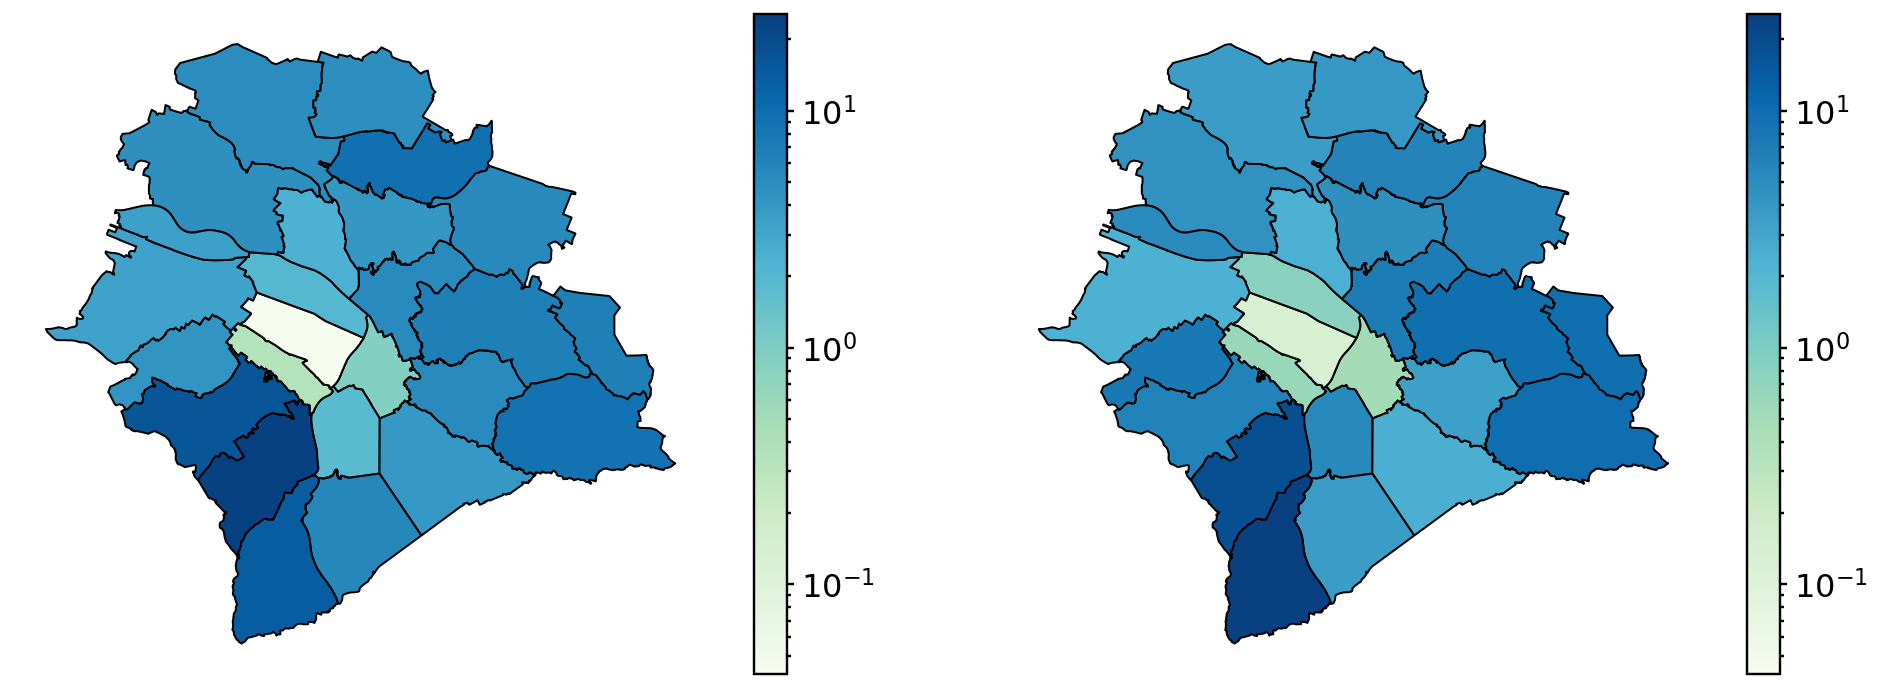

In [36]:
import matplotlib.colors 

fig=plt.figure(figsize=(14 , 5))
ax=plt.subplot(1,2,1)
#gdf_residuals.plot(column='value', cmap='GnBu', scheme='Quantiles', k=3,  ec='black',ax=ax)
gdf_residuals.plot(column='value', cmap='GnBu',  norm=matplotlib.colors.LogNorm(vmin=min(gdf_residuals.value.min(), gdf_residuals.prediction.min()),vmax=max(gdf_residuals.value.max(), gdf_residuals.prediction.max())), legend=True, ec='black',ax=ax)
ax.axis('off')
q=[25, 50, 75, 100]
thresholds=np.percentile(gdf_residuals['value'], q)
ax=plt.subplot(1,2,2)
#gdf_residuals.plot(column='prediction',  cmap='GnBu',  scheme='Quantiles', k=3,  ec='black',ax=ax)
gdf_residuals.plot(column='prediction',  cmap='GnBu', norm=matplotlib.colors.LogNorm(vmin=min(gdf_residuals.value.min(), gdf_residuals.prediction.min()),vmax=max(gdf_residuals.value.max(), gdf_residuals.prediction.max())), legend=True, ec='black',ax=ax)
ax.axis('off')
plt.tight_layout()


fig.savefig('../Figures/Pre-processing/DH_per_100ap_zurich.png',dpi=300,bbox_inches='tight')
